# Knot sizes

Comparison between different ways of measuring this. 

In [1]:
import numpy as np
import typer
from astropy.table import Table, QTable, join
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

from matplotlib import pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd

In [2]:
ORIGIN = SkyCoord.from_name("wr124", cache=True)

In [3]:
from pathlib import Path

In [4]:
datapath = Path.cwd().parent / "data" / "reproject"

## Separations between the knot peaks in different tracers

In [5]:
AA_D_table = QTable.read(datapath / "combo-AA-neutral-combo-D-neutral-knot-seps.ecsv")
DD_D_table = QTable.read(datapath / "combo-DD-neutral-combo-D-neutral-knot-seps.ecsv")
EE_D_table = QTable.read(datapath / "combo-E-ionized-combo-D-neutral-knot-seps.ecsv")

In [6]:
AA_D_table.rename_column("dR", "dR(AA-D)")
DD_D_table.rename_column("dR", "dR(DD-D)")
EE_D_table.rename_column("dR", "dR(EE-D)")

In [7]:
dr_table = join(join(AA_D_table, DD_D_table[["label", "dR(DD-D)"]]), EE_D_table[["label", "dR(EE-D)"]])

In [8]:
dr_table.show_in_notebook()

In [9]:
df = dr_table.to_pandas().set_index("label")

In [10]:
df.describe()

PA           R    dR(AA-D)    dR(DD-D)    dR(EE-D)
count  168.000000  168.000000  168.000000  168.000000  168.000000
mean   168.106306   16.993089    0.085560    0.073168    0.080267
std     98.237645    7.126710    0.074087    0.098691    0.094062
min      0.869865    2.931549   -0.160717   -0.479362   -0.249390
25%     84.269931   11.561891    0.046616    0.044192    0.034202
50%    179.449465   16.369898    0.080540    0.072164    0.082803
75%    220.170986   21.789643    0.127263    0.115126    0.126160
max    359.624498   35.220427    0.410410    0.373487    0.375196

Remove outliers

In [11]:
drmin, drmax = -0.1, 0.3
for col in df.columns:
    if col.startswith("dR"):
        m = (df[col] < drmin) | (df[col] > drmax)
        df.loc[m, col] = np.nan

In [12]:
df.describe()

PA           R    dR(AA-D)    dR(DD-D)    dR(EE-D)
count  168.000000  168.000000  163.000000  157.000000  157.000000
mean   168.106306   16.993089    0.088925    0.081707    0.081808
std     98.237645    7.126710    0.061710    0.065851    0.070412
min      0.869865    2.931549   -0.059916   -0.082465   -0.090121
25%     84.269931   11.561891    0.048029    0.047028    0.040196
50%    179.449465   16.369898    0.080967    0.075092    0.083303
75%    220.170986   21.789643    0.127441    0.114803    0.122093
max    359.624498   35.220427    0.298239    0.261382    0.273267

In [13]:
df.corr()

PA         R  dR(AA-D)  dR(DD-D)  dR(EE-D)
PA        1.000000  0.140353  0.141097  0.198037  0.222473
R         0.140353  1.000000  0.191310  0.086283  0.013085
dR(AA-D)  0.141097  0.191310  1.000000  0.608580  0.401885
dR(DD-D)  0.198037  0.086283  0.608580  1.000000  0.356736
dR(EE-D)  0.222473  0.013085  0.401885  0.356736  1.000000

Correlations between displacements are OK: 0.4 to 0.6. Best between AA-D and DD-D

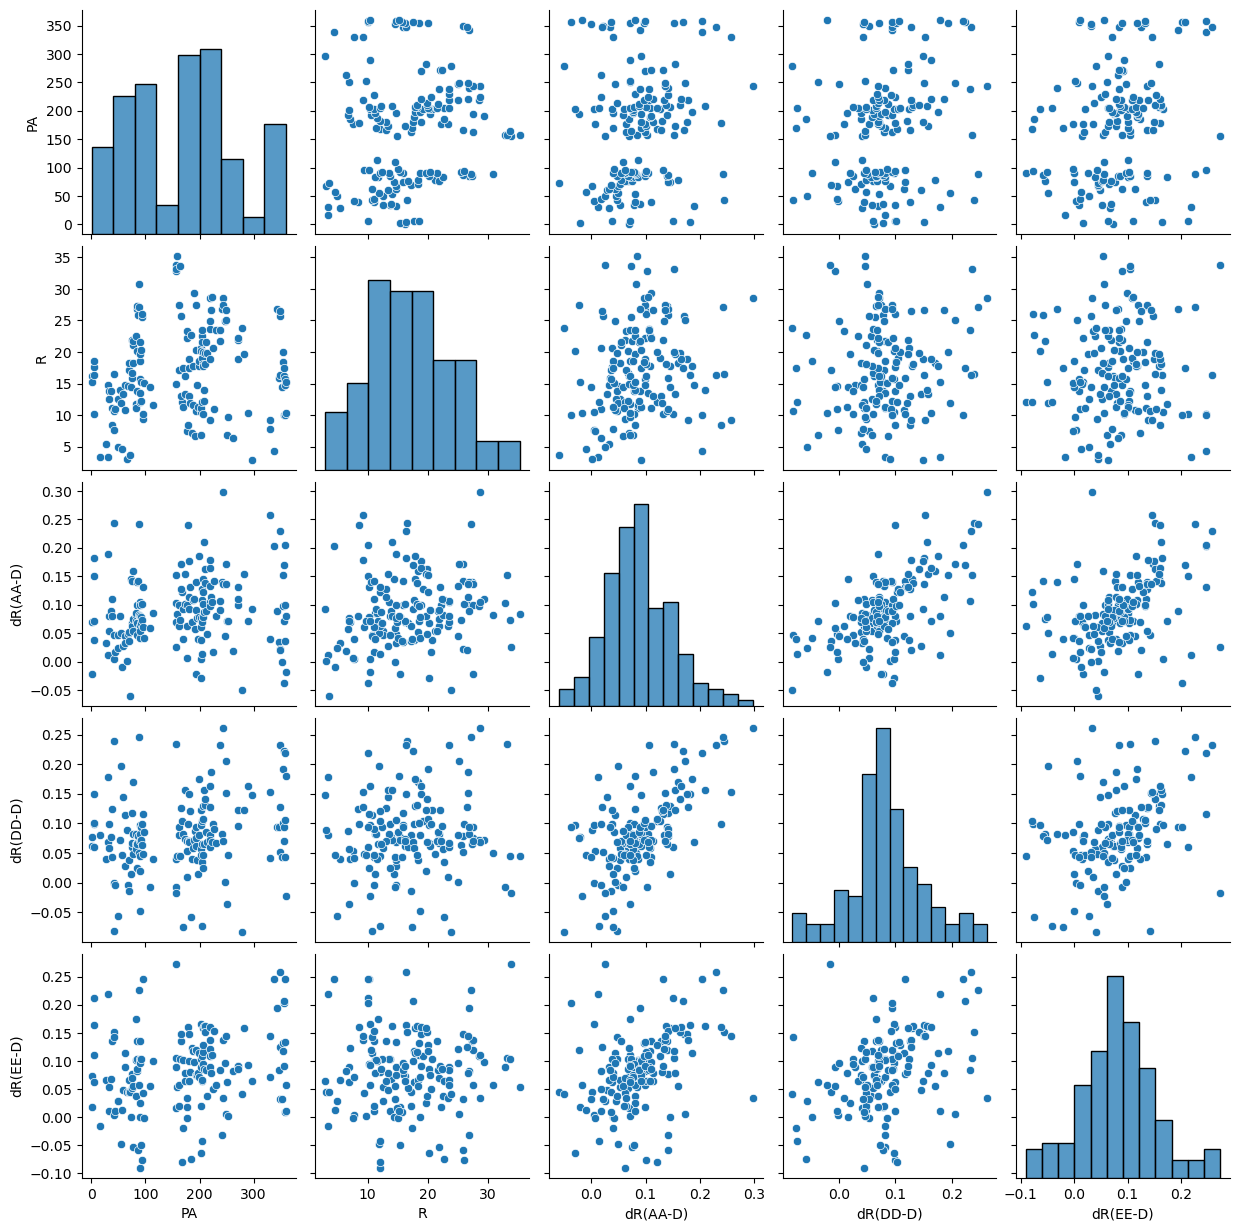

In [14]:
sns.pairplot(df)

## Sizes from fitting ellipses

In [15]:
wanted = ["label", "Ellipse Sigma X", "Ellipse Sigma Y"]
etables = {
    "AA": QTable.read(datapath / "combo-AA-neutral-knot-ellipses.ecsv")[wanted],
    "DD": QTable.read(datapath / "combo-DD-neutral-knot-ellipses.ecsv")[wanted],
    "D": QTable.read(datapath / "combo-D-neutral-knot-ellipses.ecsv")[wanted],
    "E": QTable.read(datapath / "combo-E-ionized-knot-ellipses.ecsv")[wanted],
    "H": QTable.read(datapath / "wr124-hst-2008-f656n-radec-knot-ellipses.ecsv")[wanted],
}


In [16]:
for key, tab in etables.items():
    tab.rename_columns(wanted[1:3], [f"sigx({key})", f"sigy({key})"])

In [17]:
sig_table = None
for key, tab in etables.items():
    if sig_table is None:
        sig_table = tab
    else:
        sig_table = join(sig_table, tab)

In [18]:
sig_table.show_in_notebook()

In [19]:
sdf = sig_table.to_pandas().set_index("label")

In [20]:
sdf.describe()

sigx(AA)    sigy(AA)     sigx(DD)    sigy(DD)     sigx(D)  \
count  168.000000  168.000000   168.000000  168.000000  168.000000   
mean     0.189297    0.211146     9.501654    2.057401    0.167395   
std      0.393474    0.737747   107.487746   16.534651    0.120110   
min      0.031000    0.031000     0.031000    0.031000    0.031000   
25%      0.062137    0.069250     0.080898    0.085217    0.109641   
50%      0.097967    0.095465     0.125723    0.125400    0.133674   
75%      0.152759    0.135252     0.235551    0.217215    0.186639   
max      2.732700    7.571815  1384.989686  178.880050    1.145234   

          sigy(D)     sigx(E)     sigy(E)     sigx(H)     sigy(H)  
count  168.000000  168.000000  168.000000  168.000000  168.000000  
mean     0.186697    0.410490    0.388603    0.351749    0.329259  
std      0.267581    0.546559    0.486643    0.413912    0.351359  
min      0.031000    0.031000    0.031000    0.066407    0.070087  
25%      0.113010    0.171803    0.172388    0.166643    0.172998  
50%      0.136477    0.270768    0.267675    0.235817    0.244416  
75%      0.172288    0.447755    0.425189    0.391546    0.350796  
max      3.100577    5.225164    4.911740    3.380791    3.532263

In [21]:
sdf.columns

Index(['sigx(AA)', 'sigy(AA)', 'sigx(DD)', 'sigy(DD)', 'sigx(D)', 'sigy(D)',
       'sigx(E)', 'sigy(E)', 'sigx(H)', 'sigy(H)'],
      dtype='object')

Discard extreme outliers by imposing max of 0.3 arcsec for the neutral ones and 0.6 for the ionized ones because they are bigger

In [22]:
sigmin, sigmax = 0.0, 0.3
esigmax = 0.6
for col in sdf.columns:
    if col.startswith("sig"):
        if "(E)" in col or "(H)" in col:
            smax = esigmax
        else:
            smax = sigmax
        m = (sdf[col] < sigmin) | (sdf[col] > smax)
        sdf.loc[m, col] = np.nan

In [23]:
sdf.describe()

sigx(AA)    sigy(AA)    sigx(DD)    sigy(DD)     sigx(D)     sigy(D)  \
count  153.000000  156.000000  143.000000  141.000000  158.000000  156.000000   
mean     0.103920    0.102275    0.126566    0.123100    0.144934    0.141518   
std      0.057175    0.053147    0.073222    0.064939    0.052488    0.044377   
min      0.031000    0.031000    0.031000    0.031000    0.031000    0.031000   
25%      0.059738    0.067286    0.073163    0.070514    0.108208    0.111462   
50%      0.094732    0.091467    0.106417    0.109520    0.128838    0.132771   
75%      0.139571    0.123352    0.176090    0.160502    0.166868    0.161634   
max      0.275991    0.291674    0.299825    0.295724    0.295518    0.276623   

          sigx(E)     sigy(E)     sigx(H)     sigy(H)  
count  143.000000  146.000000  152.000000  152.000000  
mean     0.263026    0.259466    0.252236    0.245802  
std      0.135906    0.138090    0.117815    0.109277  
min      0.031000    0.031000    0.066407    0.070087  
25%      0.156823    0.155681    0.161315    0.169020  
50%      0.248484    0.244081    0.212934    0.222378  
75%      0.328884    0.353069    0.345063    0.297076  
max      0.594713    0.593076    0.555056    0.595289

In [24]:
sdf.corr()

sigx(AA)  sigy(AA)  sigx(DD)  sigy(DD)   sigx(D)   sigy(D)  \
sigx(AA)  1.000000  0.692567  0.377318  0.264691  0.055568  0.111015   
sigy(AA)  0.692567  1.000000  0.341597  0.443135  0.056452  0.126335   
sigx(DD)  0.377318  0.341597  1.000000  0.781472  0.108856  0.087152   
sigy(DD)  0.264691  0.443135  0.781472  1.000000 -0.056314  0.087221   
sigx(D)   0.055568  0.056452  0.108856 -0.056314  1.000000  0.188390   
sigy(D)   0.111015  0.126335  0.087152  0.087221  0.188390  1.000000   
sigx(E)  -0.124248 -0.108651 -0.120159 -0.078976  0.070780 -0.014733   
sigy(E)   0.015918 -0.058539 -0.244930 -0.168177  0.001917 -0.037058   
sigx(H)   0.007251  0.019744 -0.086647 -0.087203  0.065681 -0.037392   
sigy(H)   0.060376  0.089280 -0.149213 -0.176038  0.094949  0.069060   

           sigx(E)   sigy(E)   sigx(H)   sigy(H)  
sigx(AA) -0.124248  0.015918  0.007251  0.060376  
sigy(AA) -0.108651 -0.058539  0.019744  0.089280  
sigx(DD) -0.120159 -0.244930 -0.086647 -0.149213  
sigy(DD) -0.078976 -0.168177 -0.087203 -0.176038  
sigx(D)   0.070780  0.001917  0.065681  0.094949  
sigy(D)  -0.014733 -0.037058 -0.037392  0.069060  
sigx(E)   1.000000  0.678676  0.673564  0.330714  
sigy(E)   0.678676  1.000000  0.441997  0.518787  
sigx(H)   0.673564  0.441997  1.000000  0.690043  
sigy(H)   0.330714  0.518787  0.690043  1.000000

We have a good correlation between x and y for the same image but we are really interested in correlations between images. So divide into the x and y sigmas to look at separately. 

In [25]:
xcols = [_ for _ in sdf.columns if _.startswith("sigx")]
ycols = [_ for _ in sdf.columns if _.startswith("sigy")]

In [26]:
sdf[xcols].corr()

sigx(AA)  sigx(DD)   sigx(D)   sigx(E)   sigx(H)
sigx(AA)  1.000000  0.377318  0.055568 -0.124248  0.007251
sigx(DD)  0.377318  1.000000  0.108856 -0.120159 -0.086647
sigx(D)   0.055568  0.108856  1.000000  0.070780  0.065681
sigx(E)  -0.124248 -0.120159  0.070780  1.000000  0.673564
sigx(H)   0.007251 -0.086647  0.065681  0.673564  1.000000

In [27]:
sdf[ycols].corr()

sigy(AA)  sigy(DD)   sigy(D)   sigy(E)   sigy(H)
sigy(AA)  1.000000  0.443135  0.126335 -0.058539  0.089280
sigy(DD)  0.443135  1.000000  0.087221 -0.168177 -0.176038
sigy(D)   0.126335  0.087221  1.000000 -0.037058  0.069060
sigy(E)  -0.058539 -0.168177 -0.037058  1.000000  0.518787
sigy(H)   0.089280 -0.176038  0.069060  0.518787  1.000000

For sigx, the best correlation is between E and H (r=0.67), which is good since they are both supposed to trace the ionized gas. 

There is moderate correlation between AA and DD (r=0.38), which both should trace the near PDR. 

The correlation with D is very weak (r~=0.1), probably because D is lower resolution, so sig never drops below 0.1 arcsec. 

Results for sigy are very similar

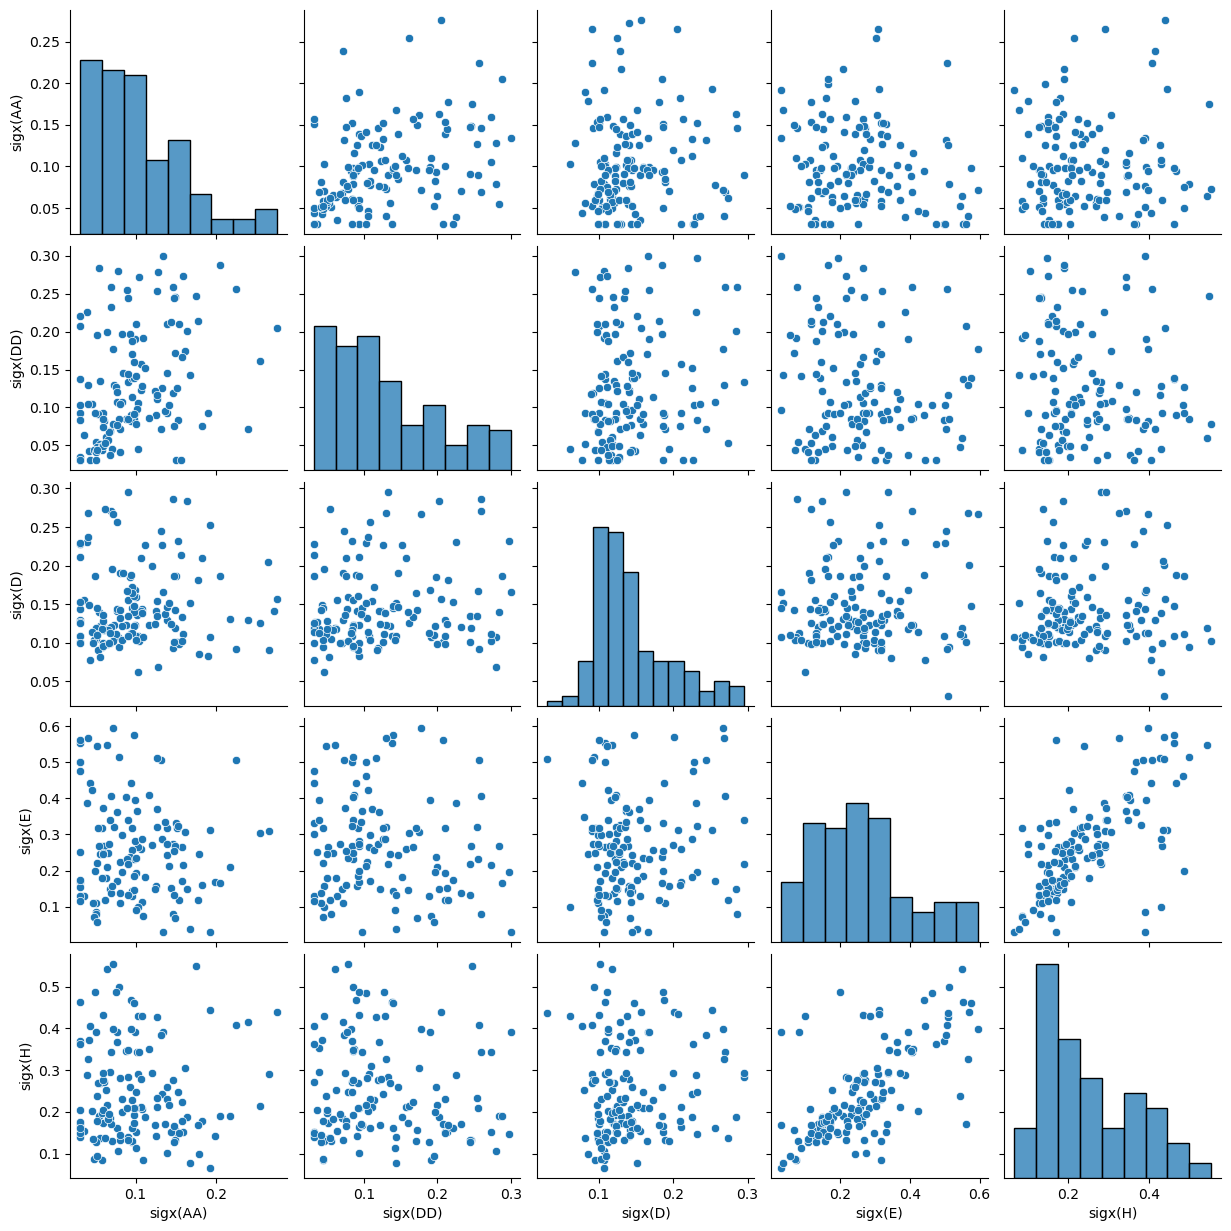

In [28]:
sns.pairplot(sdf[xcols])

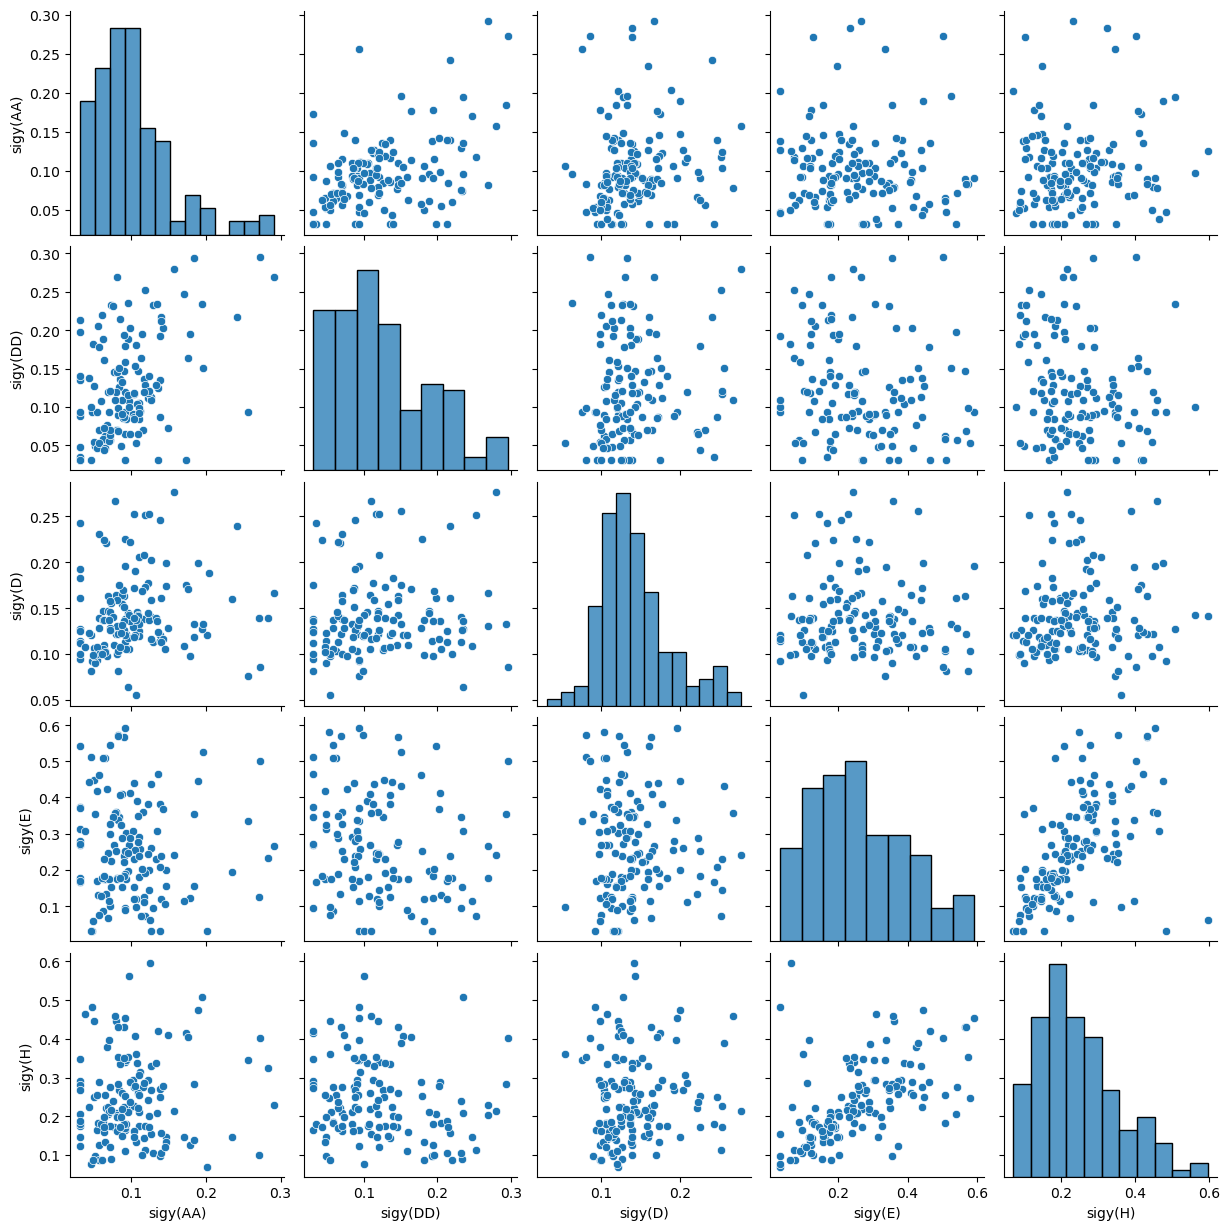

In [29]:
sns.pairplot(sdf[ycols])

## Combine the sigmas with the displacements

In [30]:
dff = df.join(sdf[xcols])

In [31]:
dff

PA          R  dR(AA-D)  dR(DD-D)  dR(EE-D)  sigx(AA)  \
label                                                                       
PA001-R163    0.869865  16.245966  0.069008  0.062543  0.072879  0.064996   
PA002-R153    2.118148  15.299324 -0.021184  0.077876  0.017620  0.189656   
PA004-R164    4.409480  16.306989  0.181498  0.150238  0.163767  0.150846   
PA005-R101    5.007312  10.120692  0.150315  0.059856  0.212847  0.163425   
PA005-R178    5.273182  17.682355  0.038197  0.099070  0.062554  0.043646   
...                ...        ...       ...       ...       ...       ...   
PA357-R101  357.463180  10.003384  0.204484  0.218715  0.246611  0.226531   
PA357-R148  357.133878  14.717319  0.099425  0.106577  0.133486  0.059955   
PA357-R158  356.791878  15.718994  0.035790  0.043918  0.008706  0.147676   
PA359-R104  359.286607  10.309558 -0.017631 -0.021567  0.056880  0.177635   
PA360-R153  359.624498  15.274069  0.080967  0.179607  0.010443  0.049553   

            sigx(DD)   sigx(D)   sigx(E)   sigx(H)  
label                                               
PA001-R163  0.060249  0.118240  0.548360  0.543568  
PA002-R153  0.093000  0.082290       NaN       NaN  
PA004-R164  0.031000  0.186325  0.332115  0.151387  
PA005-R101  0.201439  0.284199  0.148716  0.188208  
PA005-R178  0.031000  0.077562  0.442776  0.404745  
...              ...       ...       ...       ...  
PA357-R101       NaN       NaN       NaN       NaN  
PA357-R148  0.074331  0.136212  0.372258  0.292871  
PA357-R158  0.075448  0.187018  0.253646  0.166965  
PA359-R104  0.214231  0.181146  0.117382  0.168596  
PA360-R153  0.093000  0.186513  0.199236  0.487044  

[168 rows x 10 columns]

Eliminate negative dR

In [32]:
for col in dff.columns:
    if col.startswith("dR"):
        m = dff[col] <= 0.0
        dff.loc[m, col] = np.nan

In [33]:
dff.corr()

PA         R  dR(AA-D)  dR(DD-D)  dR(EE-D)  sigx(AA)  \
PA        1.000000  0.140353  0.217603  0.211779  0.165332  0.036593   
R         0.140353  1.000000  0.175869  0.078587  0.020306 -0.297810   
dR(AA-D)  0.217603  0.175869  1.000000  0.583326  0.462531 -0.011335   
dR(DD-D)  0.211779  0.078587  0.583326  1.000000  0.398124  0.119774   
dR(EE-D)  0.165332  0.020306  0.462531  0.398124  1.000000  0.183262   
sigx(AA)  0.036593 -0.297810 -0.011335  0.119774  0.183262  1.000000   
sigx(DD)  0.003411 -0.263704 -0.067508  0.091240  0.110798  0.377318   
sigx(D)   0.054525 -0.012883  0.011790  0.155118  0.118572  0.055568   
sigx(E)  -0.091589  0.125402 -0.071275 -0.153383  0.026624 -0.124248   
sigx(H)  -0.172722  0.100190 -0.110820  0.020317 -0.037470  0.007251   

          sigx(DD)   sigx(D)   sigx(E)   sigx(H)  
PA        0.003411  0.054525 -0.091589 -0.172722  
R        -0.263704 -0.012883  0.125402  0.100190  
dR(AA-D) -0.067508  0.011790 -0.071275 -0.110820  
dR(DD-D)  0.091240  0.155118 -0.153383  0.020317  
dR(EE-D)  0.110798  0.118572  0.026624 -0.037470  
sigx(AA)  0.377318  0.055568 -0.124248  0.007251  
sigx(DD)  1.000000  0.108856 -0.120159 -0.086647  
sigx(D)   0.108856  1.000000  0.070780  0.065681  
sigx(E)  -0.120159  0.070780  1.000000  0.673564  
sigx(H)  -0.086647  0.065681  0.673564  1.000000

In [34]:
drcols = [_ for _ in dff.columns if _.startswith("dR")]

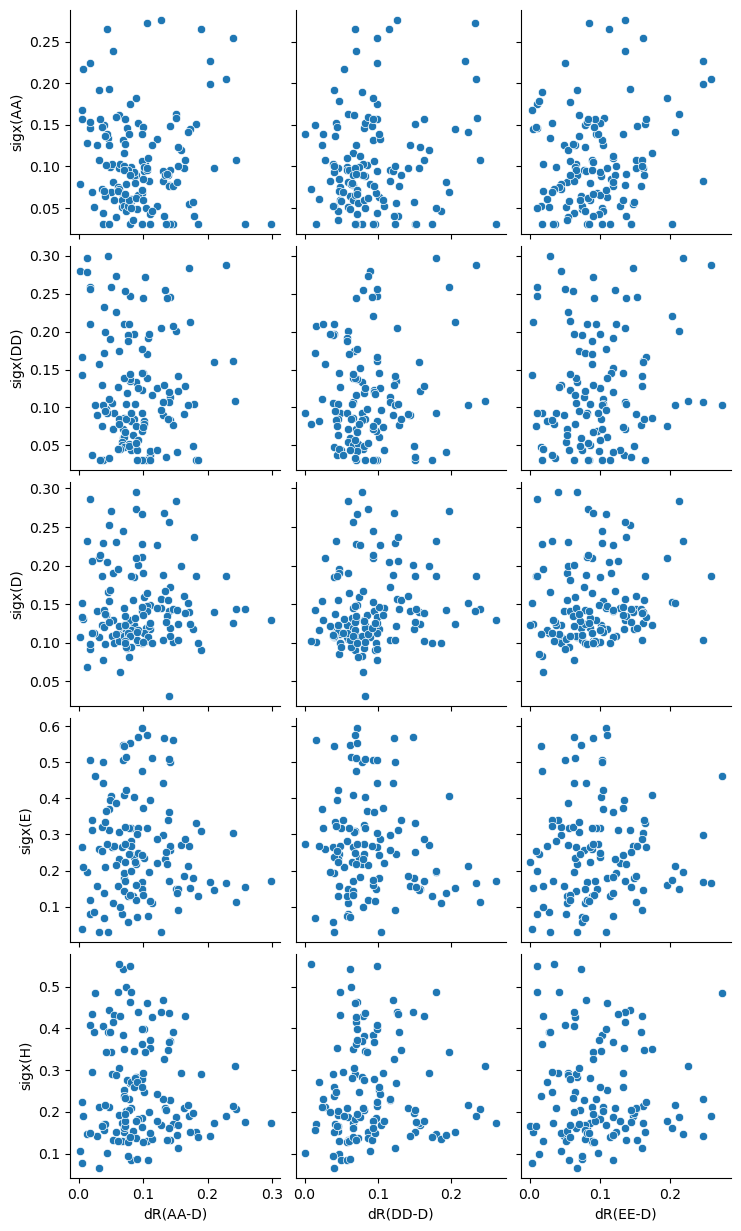

In [35]:
sns.pairplot(dff, x_vars=drcols, y_vars=xcols)

In [36]:
cdf = dff[drcols + xcols].corr()
sol = (cdf.where(np.triu(np.ones(cdf.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
sol.head(15)

sigx(E)   sigx(H)     0.673564
dR(AA-D)  dR(DD-D)    0.583326
          dR(EE-D)    0.462531
dR(DD-D)  dR(EE-D)    0.398124
sigx(AA)  sigx(DD)    0.377318
dR(EE-D)  sigx(AA)    0.183262
dR(DD-D)  sigx(D)     0.155118
          sigx(AA)    0.119774
dR(EE-D)  sigx(D)     0.118572
          sigx(DD)    0.110798
sigx(DD)  sigx(D)     0.108856
dR(DD-D)  sigx(DD)    0.091240
sigx(D)   sigx(E)     0.070780
          sigx(H)     0.065681
sigx(AA)  sigx(D)     0.055568
dtype: float64

So the numbers say that the best dR-sigx correlation 

```
 	 	 	dR(AA-D)	dR(DD-D)	dR(EE-D)
 	 	 	-------- 	-------- 	--------
sigx(AA)	-0.011335	0.119774	0.183262
sigx(DD)	-0.067508	0.091240	0.110798
sigx(D)		0.011790	0.155118	0.118572
sigx(E) 	-0.071275	-0.153383	0.026624
sigx(H) 	-0.110820	0.020317	-0.037470	

```
is between dR(EE-D) and sigx(AA) with r=0.18 (not great!)

But all the dR(DD-D) and dR(EE-D) correlations with sigx(AA), sigx(DD), sigx(D) are similar (r=0.1 to 0.2)

Apart from that, there are non-existent or negative correlations for dR(AA-D) with all sigx, and for all dR with sigx(E) and (H).

*We clearly need better measurements of the widths*

## Use the new sizes from peak photometry

In [370]:
ptables = {
    "AA": QTable.read(datapath / "combo-AA-neutral-knot-peak-stats.ecsv"),
    "DD": QTable.read(datapath / "combo-DD-neutral-knot-peak-stats.ecsv"),
    "D": QTable.read(datapath / "combo-D-neutral-knot-peak-stats.ecsv"),
    "E": QTable.read(datapath / "combo-E-ionized-knot-peak-stats.ecsv"),
    "H": QTable.read(datapath / "wr124-hst-2008-f656n-radec-knot-peak-stats.ecsv"),
}


In [371]:
ptables["H"].show_in_notebook()

Switch to pandas dataframes to make life easier

In [372]:
peakdfs = {k: v.to_pandas().set_index("label") for k, v in ptables.items()}

### Look at the summary statistics of all columns for each tracer

In [373]:
peakdfs["H"].describe()

Peak Center.ra  Peak Center.dec  Gauss Center.ra  Gauss Center.dec  \
count      168.000000       168.000000       168.000000        168.000000   
mean       287.879008        16.859590       287.879005         16.859587   
std          0.003605         0.003648         0.003608          0.003652   
min        287.871195        16.851527       287.871199         16.851528   
25%        287.876909        16.856659       287.876908         16.856655   
50%        287.878681        16.860396       287.878672         16.860388   
75%        287.881570        16.862103       287.881556         16.862104   
max        287.887598        16.867776       287.887593         16.867804   

            r_eff       r_rms  Gauss sigma  Bright Peak  Bright Gauss  \
count  162.000000  163.000000   168.000000   168.000000    168.000000   
mean     0.134816    0.147955     0.123381     0.305729      0.310316   
std      0.022596    0.055855     0.031613     0.182282      0.192945   
min      0.038236    0.076845     0.031000     0.028375      0.035984   
25%      0.120568    0.135847     0.103812     0.161150      0.169761   
50%      0.139743    0.144932     0.117628     0.276920      0.277247   
75%      0.151282    0.151912     0.135562     0.390903      0.419038   
max      0.185845    0.815047     0.280287     0.914141      0.925446   

        Core flux   Bright BG      MAD BG  Fill fraction  NaN fraction  \
count  168.000000  168.000000  168.000000     168.000000    168.000000   
mean    19.064907    0.524678    0.072930       0.283012      0.001278   
std     15.047744    0.296199    0.060046       0.127805      0.016559   
min    -18.265301    0.062487    0.003849      -0.570902      0.000000   
25%      9.255576    0.310822    0.033329       0.225779      0.000000   
50%     16.225781    0.461093    0.052555       0.305814      0.000000   
75%     26.229856    0.672147    0.093944       0.367129      0.000000   
max     72.290367    1.419276    0.314001       0.548102      0.214634   

         Peak SNR  
count  168.000000  
mean     5.949835  
std      4.206777  
min      1.000450  
25%      2.761408  
50%      5.197484  
75%      7.386577  
max     26.374762

In [374]:
peakdfs["E"].describe()

Peak Center.ra  Peak Center.dec  Gauss Center.ra  Gauss Center.dec  \
count      168.000000       168.000000       168.000000        168.000000   
mean       287.878998        16.859590       287.878998         16.859585   
std          0.003607         0.003647         0.003607          0.003654   
min        287.871177        16.851527       287.871178         16.851488   
25%        287.876887        16.856661       287.876900         16.856655   
50%        287.878659        16.860388       287.878660         16.860388   
75%        287.881565        16.862103       287.881553         16.862100   
max        287.887580        16.867793       287.887601         16.867817   

            r_eff       r_rms  Gauss sigma  Bright Peak  Bright Gauss  \
count  154.000000  163.000000   168.000000   168.000000    168.000000   
mean     0.119752    0.155808     0.130508     2.106646      2.157948   
std      0.028501    0.070699     0.112000     1.555840      1.582794   
min      0.008357    0.061617     0.031000     0.237470      0.000000   
25%      0.102619    0.132076     0.097874     1.128746      1.049312   
50%      0.121474    0.147713     0.114418     1.912173      1.897144   
75%      0.139749    0.158148     0.140769     2.678119      2.781449   
max      0.174826    0.862723     1.458872    12.926495     12.937780   

        Core flux   Bright BG      MAD BG  Fill fraction  NaN fraction  \
count  168.000000  168.000000  168.000000     168.000000    168.000000   
mean   103.138466    4.594588    0.565246       0.212639      0.023543   
std    100.272491    2.118069    0.516192       0.144477      0.100585   
min    -96.685791    0.917039    0.061218      -0.597529      0.000000   
25%     41.214448    3.236648    0.242019       0.156381      0.000000   
50%     82.666225    4.288479    0.430921       0.219998      0.000000   
75%    157.386044    5.733996    0.685533       0.306068      0.000000   
max    743.690552   12.476694    4.443333       0.485033      0.699507   

         Peak SNR  
count  168.000000  
mean     5.013042  
std      3.333603  
min      0.939677  
25%      2.576965  
50%      4.006191  
75%      6.564558  
max     18.997458

So E and H are very similar, as would be expected, with r = 0.1 to 0.2, but a tail down to low values (probably spurious). The effective radius r_eff seems better behaved than the rms radius r_rms, which has some large outliers. 

In [375]:
peakdfs["D"].describe()

Peak Center.ra  Peak Center.dec  Gauss Center.ra  Gauss Center.dec  \
count      168.000000       168.000000       168.000000        168.000000   
mean       287.878999        16.859586       287.878996         16.859587   
std          0.003615         0.003662         0.003618          0.003666   
min        287.871159        16.851501       287.871151         16.851495   
25%        287.876873        16.856642       287.876853         16.856640   
50%        287.878677        16.860370       287.878679         16.860369   
75%        287.881660        16.862099       287.881660         16.862094   
max        287.887598        16.867819       287.887594         16.867856   

            r_eff       r_rms  Gauss sigma  Bright Peak  Bright Gauss  \
count  162.000000  166.000000   168.000000   168.000000    168.000000   
mean     0.121207    0.156677     0.111252     4.190383      4.462695   
std      0.024765    0.020866     0.029065     4.362402      4.891813   
min      0.020571    0.102242     0.046199     0.061891      0.000000   
25%      0.112927    0.143243     0.095904     1.319496      1.329122   
50%      0.124290    0.154150     0.106065     2.684025      2.742343   
75%      0.135462    0.165672     0.118122     5.843078      6.055809   
max      0.170080    0.265384     0.334667    31.708973     30.703155   

         Core flux   Bright BG      MAD BG  Fill fraction  NaN fraction  \
count   168.000000  168.000000  168.000000     168.000000    168.000000   
mean    207.357635    1.248735    0.546330       0.226140      0.023859   
std     294.663422    1.458878    0.990632       0.134645      0.103303   
min    -846.744873   -0.693198    0.030078      -0.698303      0.000000   
25%      50.548493    0.480687    0.131490       0.197979      0.000000   
50%     120.407478    0.807338    0.245770       0.246184      0.000000   
75%     265.819183    1.312100    0.581448       0.292025      0.000000   
max    2389.364746   11.482048    7.319968       0.463557      0.746341   

         Peak SNR  
count  168.000000  
mean    12.146069  
std      8.056336  
min      1.384786  
25%      5.651320  
50%     10.114613  
75%     16.845580  
max     41.110630

D is slightly smaller, but not much

In [376]:
peakdfs["DD"].describe()

Peak Center.ra  Peak Center.dec  Gauss Center.ra  Gauss Center.dec  \
count      168.000000       168.000000       168.000000        168.000000   
mean       287.878996        16.859591       287.878994         16.859592   
std          0.003598         0.003643         0.003600          0.003646   
min        287.871221        16.851526       287.871220         16.851522   
25%        287.876884        16.856669       287.876859         16.856663   
50%        287.878668        16.860370       287.878663         16.860371   
75%        287.881624        16.862103       287.881579         16.862061   
max        287.887579        16.867804       287.887579         16.867805   

            r_eff       r_rms  Gauss sigma  Bright Peak  Bright Gauss  \
count  163.000000  161.000000   168.000000   168.000000    168.000000   
mean     0.080461    0.120105     0.081855     1.102091      4.071728   
std      0.021635    0.024976     0.046526     1.312741     24.771109   
min      0.008589    0.046203     0.031000     0.099436      0.000000   
25%      0.068541    0.106476     0.055793     0.502415      0.385166   
50%      0.082611    0.117284     0.071961     0.747017      0.646947   
75%      0.096401    0.128496     0.090612     1.200506      1.112823   
max      0.136465    0.254499     0.340711     8.624065    277.839846   

        Core flux   Bright BG      MAD BG  Fill fraction  NaN fraction  \
count  168.000000  168.000000  168.000000     168.000000    168.000000   
mean    26.646385    0.060727    0.126630       0.164900      0.025650   
std     54.470402    0.290012    0.168204       0.096580      0.114183   
min    -66.279167   -0.975571    0.019335      -0.319075      0.000000   
25%      9.097933   -0.044764    0.045409       0.107497      0.000000   
50%     16.349539    0.049018    0.070576       0.164699      0.000000   
75%     25.470577    0.159442    0.138824       0.230074      0.000000   
max    525.029907    1.720240    1.137174       0.457742      0.812030   

         Peak SNR  
count  168.000000  
mean    11.729678  
std      8.565203  
min      1.362535  
25%      5.890320  
50%      8.924590  
75%     14.648630  
max     53.481682

In [377]:
peakdfs["AA"].describe()

Peak Center.ra  Peak Center.dec  Gauss Center.ra  Gauss Center.dec  \
count      168.000000       168.000000       168.000000        168.000000   
mean       287.878995        16.859595       287.878993         16.859592   
std          0.003598         0.003647         0.003602          0.003649   
min        287.871221        16.851527       287.871220         16.851533   
25%        287.876891        16.856671       287.876797         16.856665   
50%        287.878663        16.860378       287.878657         16.860379   
75%        287.881617        16.862101       287.881625         16.862088   
max        287.887573        16.867845       287.887579         16.867888   

            r_eff       r_rms  Gauss sigma  Bright Peak  Bright Gauss  \
count  163.000000  164.000000   168.000000   168.000000    168.000000   
mean     0.086383    0.114486     0.080683     0.823877      4.992400   
std      0.019318    0.020708     0.040913     0.603678     43.528572   
min      0.009852    0.041744     0.031000     0.077199      0.043888   
25%      0.075970    0.102833     0.057743     0.472638      0.411024   
50%      0.087761    0.113634     0.073847     0.719755      0.615258   
75%      0.100926    0.126108     0.090020     1.017346      0.965609   
max      0.120789    0.181761     0.329408     5.060822    558.369948   

        Core flux   Bright BG      MAD BG  Fill fraction  NaN fraction  \
count  168.000000  168.000000  168.000000     168.000000    168.000000   
mean    20.506058    0.197972    0.106593       0.179447      0.116203   
std     23.246660    0.290531    0.116698       0.138750      0.243694   
min   -122.521667   -0.687415    0.018750      -1.098432      0.000000   
25%      9.037608    0.059536    0.044633       0.139789      0.000000   
50%     16.970667    0.155526    0.069474       0.191489      0.000000   
75%     26.470882    0.272853    0.122469       0.252356      0.049242   
max    143.377777    2.549038    0.871637       0.369733      0.937500   

         Peak SNR  
count  168.000000  
mean    10.563772  
std      6.562427  
min      1.294540  
25%      5.617043  
50%      9.573594  
75%     13.896221  
max     34.181023

### Do sigma clipping of each column

This is to eliminate outliers in the radius measurements

In [378]:
from astropy.stats import sigma_clip

In [379]:
def clip_dataframe(df: pd.DataFrame, columns: list, sig: float=3.0):
    "Perform in-place sigma clipping on some columns of a dataframe"
    for col in columns:
        clipped = sigma_clip(df[col].values, sigma=sig)
        df.loc[clipped.mask, col] = np.nan

In [380]:
def purge_high_nanfracs(df: pd.DataFrame, columns, max_allowed: float=1.0):
    m = df["NaN fraction"] > max_allowed
    for col in columns:
        df.loc[m, col] = np.nan   

In [381]:
rcols = ["r_eff", "r_rms", "Gauss sigma"]
bcols = ["Bright Peak", "Bright BG", "Bright Gauss", "MAD BG"]

In [382]:
for combo in peakdfs:
    clip_dataframe(peakdfs[combo], rcols, sig=4)
    purge_high_nanfracs(peakdfs[combo], rcols + bcols, max_allowed=0.1)
   

Check that it worked.

In [383]:
peakdfs["H"].describe()

Peak Center.ra  Peak Center.dec  Gauss Center.ra  Gauss Center.dec  \
count      168.000000       168.000000       168.000000        168.000000   
mean       287.879008        16.859590       287.879005         16.859587   
std          0.003605         0.003648         0.003608          0.003652   
min        287.871195        16.851527       287.871199         16.851528   
25%        287.876909        16.856659       287.876908         16.856655   
50%        287.878681        16.860396       287.878672         16.860388   
75%        287.881570        16.862103       287.881556         16.862104   
max        287.887598        16.867776       287.887593         16.867804   

            r_eff       r_rms  Gauss sigma  Bright Peak  Bright Gauss  \
count  160.000000  161.000000   165.000000   167.000000    167.000000   
mean     0.135546    0.143193     0.121711     0.306303      0.310788   
std      0.021335    0.017104     0.027978     0.182678      0.193428   
min      0.056848    0.076845     0.031000     0.028375      0.035984   
25%      0.120880    0.135425     0.103782     0.160735      0.169074   
50%      0.140086    0.144858     0.117178     0.277258      0.279371   
75%      0.151421    0.151563     0.134857     0.391225      0.419560   
max      0.185845    0.200971     0.227197     0.914141      0.925446   

        Core flux   Bright BG      MAD BG  Fill fraction  NaN fraction  \
count  168.000000  167.000000  167.000000     168.000000    168.000000   
mean    19.064907    0.521640    0.072266       0.283012      0.001278   
std     15.047744    0.294452    0.059605       0.127805      0.016559   
min    -18.265301    0.062487    0.003849      -0.570902      0.000000   
25%      9.255576    0.310506    0.033165       0.225779      0.000000   
50%     16.225781    0.458490    0.052486       0.305814      0.000000   
75%     26.229856    0.668580    0.091791       0.367129      0.000000   
max     72.290367    1.419276    0.314001       0.548102      0.214634   

         Peak SNR  
count  168.000000  
mean     5.949835  
std      4.206777  
min      1.000450  
25%      2.761408  
50%      5.197484  
75%      7.386577  
max     26.374762

### Look at correlations or r_eff with r_rms within each combo

In [384]:
peakdfs["E"][rcols + bcols].corr()

r_eff     r_rms  Gauss sigma  Bright Peak  Bright BG  \
r_eff         1.000000  0.222501     0.167128     0.198710   0.079265   
r_rms         0.222501  1.000000     0.196596    -0.084847   0.016973   
Gauss sigma   0.167128  0.196596     1.000000     0.083374   0.086378   
Bright Peak   0.198710 -0.084847     0.083374     1.000000   0.685020   
Bright BG     0.079265  0.016973     0.086378     0.685020   1.000000   
Bright Gauss  0.178492 -0.023844     0.120436     0.917321   0.660396   
MAD BG       -0.031934  0.024104     0.290225     0.581407   0.698796   

              Bright Gauss    MAD BG  
r_eff             0.178492 -0.031934  
r_rms            -0.023844  0.024104  
Gauss sigma       0.120436  0.290225  
Bright Peak       0.917321  0.581407  
Bright BG         0.660396  0.698796  
Bright Gauss      1.000000  0.546614  
MAD BG            0.546614  1.000000

In [457]:
peakdfs["E"].loc[peakdfs["E"]["Peak SNR"] > 10][rcols + bcols].corr()

r_eff     r_rms  Gauss sigma  Bright Peak  Bright BG  \
r_eff         1.000000  0.657940     0.693785     0.214849   0.254128   
r_rms         0.657940  1.000000     0.761976     0.311699   0.374978   
Gauss sigma   0.693785  0.761976     1.000000     0.453082   0.488457   
Bright Peak   0.214849  0.311699     0.453082     1.000000   0.733168   
Bright BG     0.254128  0.374978     0.488457     0.733168   1.000000   
Bright Gauss  0.220933  0.310970     0.372085     0.983473   0.727327   
MAD BG        0.362629  0.380159     0.550566     0.974157   0.715826   

              Bright Gauss    MAD BG  
r_eff             0.220933  0.362629  
r_rms             0.310970  0.380159  
Gauss sigma       0.372085  0.550566  
Bright Peak       0.983473  0.974157  
Bright BG         0.727327  0.715826  
Bright Gauss      1.000000  0.955924  
MAD BG            0.955924  1.000000

In [385]:
sns.set_color_codes()

In [486]:
def rpairplot(combo, limits=[0.07, 0.2], dr=0.03):
    g = sns.pairplot(
        peakdfs[combo], vars=rcols, corner=True, 
        plot_kws=dict(alpha=0.8, hue=peakdfs[combo]["Peak SNR"]),
        diag_kws=dict(color="r"),
    )
    xx = np.array(limits)
    g.axes[1, 0].plot(xx, xx, "--", color="k", lw=1)
    g.axes[1, 0].fill_between(xx, xx - dr, xx + dr, color="k", lw=0, alpha=0.05, zorder=-1)    
    g.axes[2, 0].plot(xx, xx / np.sqrt(2), "--", color="k", lw=1)
    g.axes[2, 0].fill_between(xx, (xx - dr) / np.sqrt(2), (xx + dr) / np.sqrt(2), color="k", lw=0, alpha=0.05, zorder=-1)
    g.axes[2, 1].plot(xx, xx / np.sqrt(2), "--", color="k", lw=1)
    g.axes[2, 1].fill_between(xx, (xx - dr) / np.sqrt(2), (xx + dr) / np.sqrt(2), color="k", lw=0, alpha=0.05, zorder=-1)

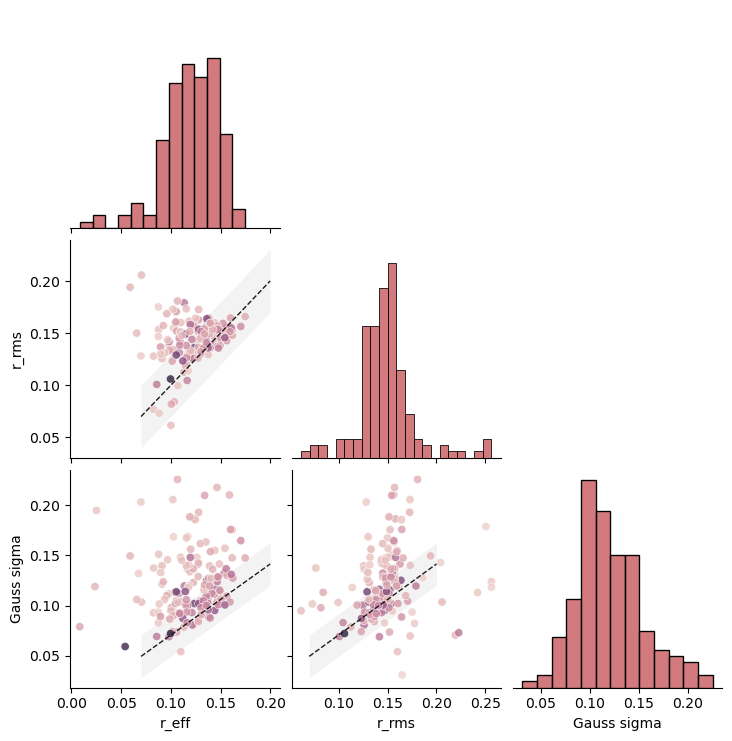

In [487]:
rpairplot("E")

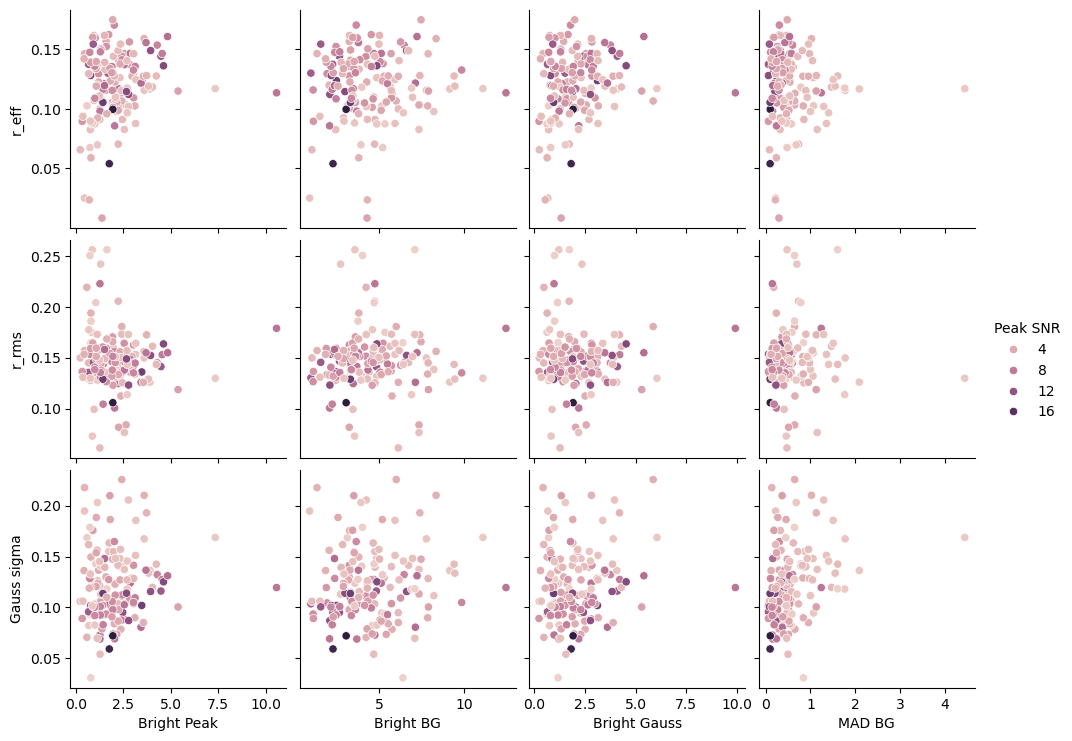

In [388]:
sns.pairplot(peakdfs["E"], x_vars=bcols, y_vars=rcols, hue="Peak SNR")

In [389]:
peakdfs["H"][rcols + bcols].corr()

r_eff     r_rms  Gauss sigma  Bright Peak  Bright BG  \
r_eff         1.000000  0.415828     0.142356     0.267526   0.049432   
r_rms         0.415828  1.000000     0.465478     0.058522  -0.002462   
Gauss sigma   0.142356  0.465478     1.000000     0.014387   0.028316   
Bright Peak   0.267526  0.058522     0.014387     1.000000   0.618829   
Bright BG     0.049432 -0.002462     0.028316     0.618829   1.000000   
Bright Gauss  0.260173  0.052534    -0.009044     0.974578   0.602404   
MAD BG       -0.096772  0.092098     0.207370     0.531753   0.725938   

              Bright Gauss    MAD BG  
r_eff             0.260173 -0.096772  
r_rms             0.052534  0.092098  
Gauss sigma      -0.009044  0.207370  
Bright Peak       0.974578  0.531753  
Bright BG         0.602404  0.725938  
Bright Gauss      1.000000  0.534225  
MAD BG            0.534225  1.000000

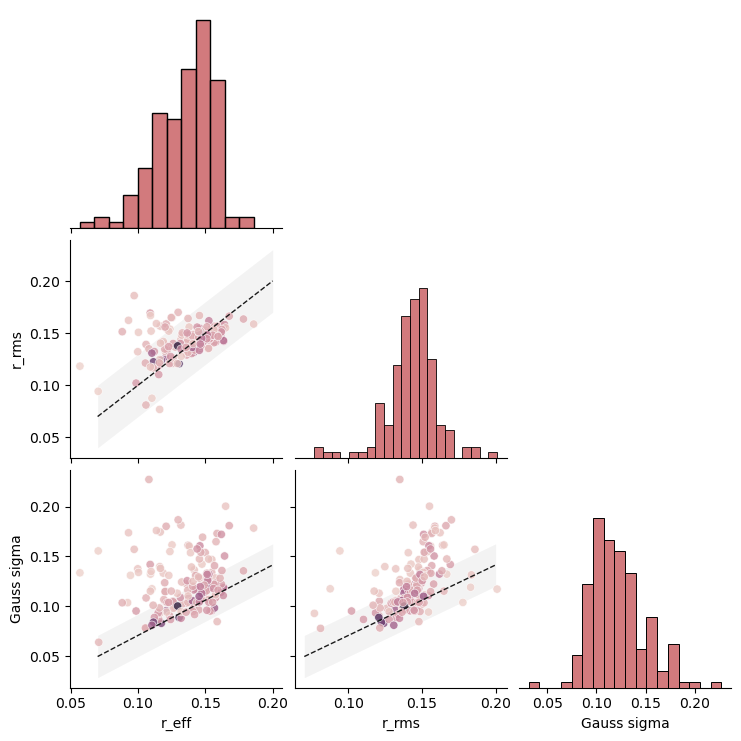

In [488]:
rpairplot("H")

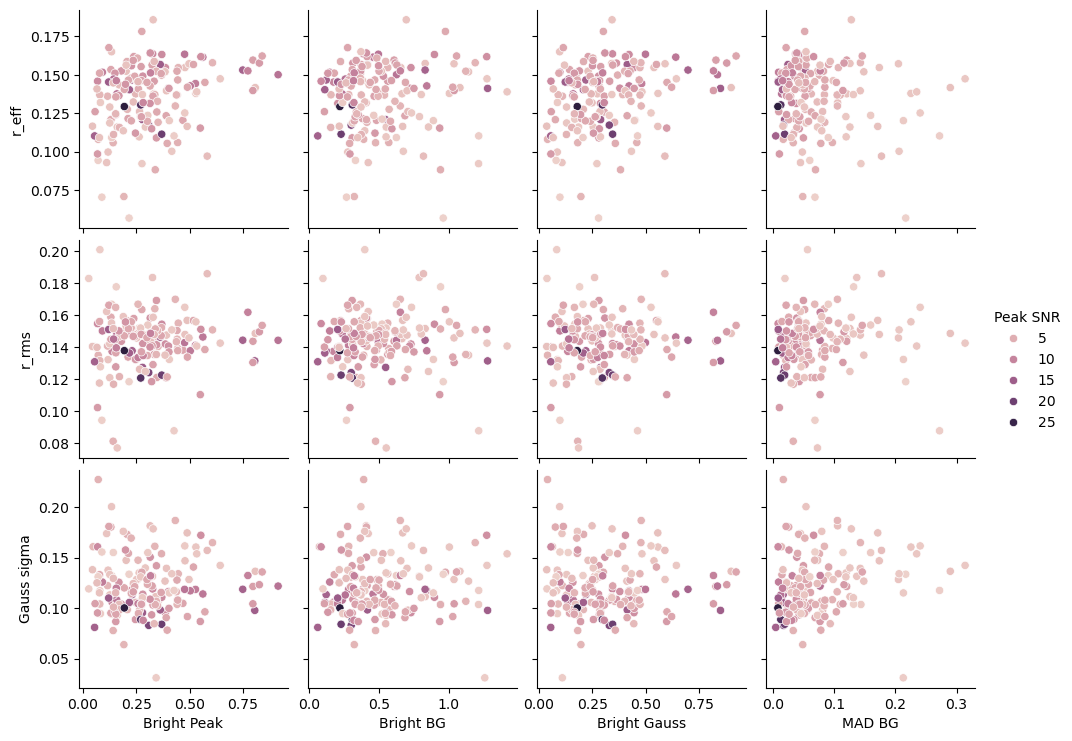

In [391]:
sns.pairplot(peakdfs["H"], x_vars=bcols, y_vars=rcols, hue="Peak SNR")

In [392]:
peakdfs["D"][rcols + bcols].corr()

r_eff     r_rms  Gauss sigma  Bright Peak  Bright BG  \
r_eff         1.000000 -0.547997     0.044804     0.155496   0.035642   
r_rms        -0.547997  1.000000     0.245209    -0.036359  -0.230588   
Gauss sigma   0.044804  0.245209     1.000000     0.125412   0.159336   
Bright Peak   0.155496 -0.036359     0.125412     1.000000   0.629324   
Bright BG     0.035642 -0.230588     0.159336     0.629324   1.000000   
Bright Gauss  0.139300 -0.013694     0.122624     0.982787   0.639828   
MAD BG       -0.052243 -0.142489     0.200919     0.580070   0.904331   

              Bright Gauss    MAD BG  
r_eff             0.139300 -0.052243  
r_rms            -0.013694 -0.142489  
Gauss sigma       0.122624  0.200919  
Bright Peak       0.982787  0.580070  
Bright BG         0.639828  0.904331  
Bright Gauss      1.000000  0.601539  
MAD BG            0.601539  1.000000

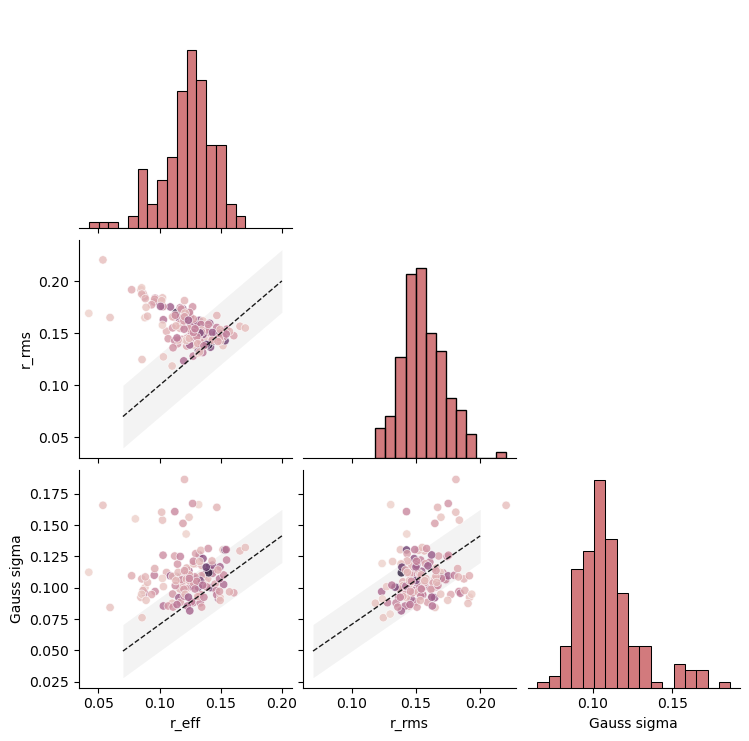

In [489]:
rpairplot("D")

Weird that correlation is negative with D. This is probably because the psf width is comparable, with fwhm = 0.146 arcsec, so sigma = 0.06. I suspect that the 2d rms is sqrt(2) times bigger, so 0.09, which means that the smaller values of r_eff are spurious. 

Peak of both is about 0.12, which after correcting for psf is:

In [394]:
np.sqrt(0.12**2 - 0.09**2)

0.07937253933193772

So about 0.1 arcsec. But still need to think how that relates to r_0


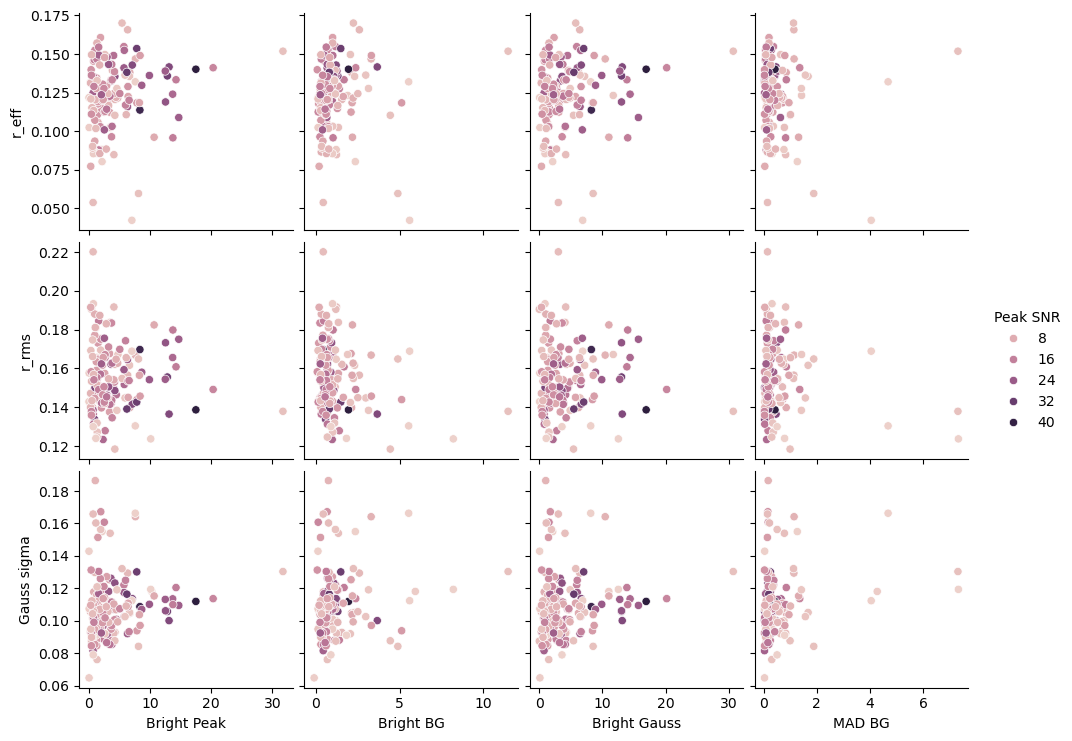

In [395]:
sns.pairplot(peakdfs["D"], x_vars=bcols, y_vars=rcols, hue="Peak SNR")

In [396]:
peakdfs["AA"][rcols + bcols].corr()

r_eff     r_rms  Gauss sigma  Bright Peak  Bright BG  \
r_eff         1.000000  0.080547     0.602489     0.288776   0.082057   
r_rms         0.080547  1.000000     0.329404     0.074838   0.291346   
Gauss sigma   0.602489  0.329404     1.000000     0.129889   0.308777   
Bright Peak   0.288776  0.074838     0.129889     1.000000   0.114779   
Bright BG     0.082057  0.291346     0.308777     0.114779   1.000000   
Bright Gauss  0.246421  0.125028    -0.018898     0.935779   0.111907   
MAD BG        0.165461  0.331545     0.402073     0.401334   0.687220   

              Bright Gauss    MAD BG  
r_eff             0.246421  0.165461  
r_rms             0.125028  0.331545  
Gauss sigma      -0.018898  0.402073  
Bright Peak       0.935779  0.401334  
Bright BG         0.111907  0.687220  
Bright Gauss      1.000000  0.364641  
MAD BG            0.364641  1.000000

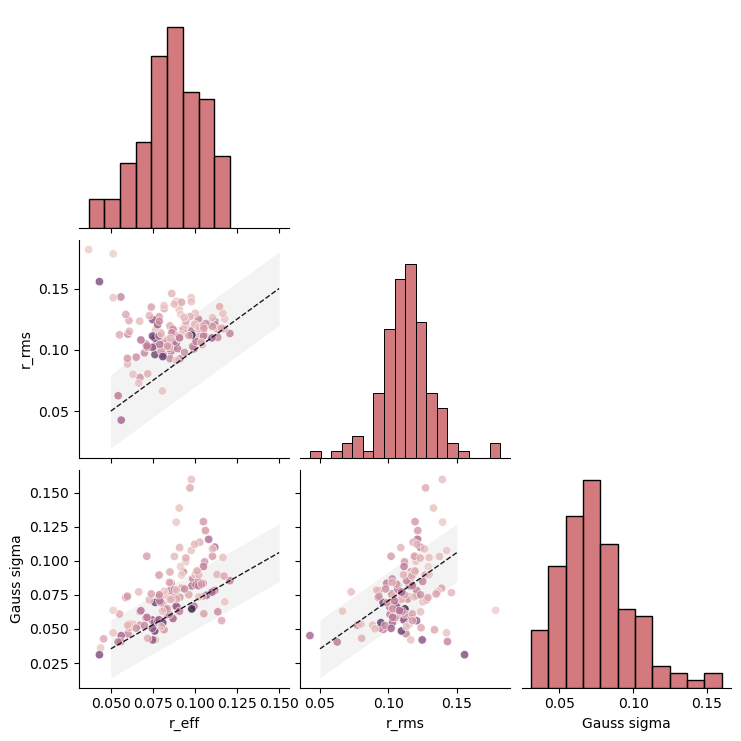

In [491]:
rpairplot("AA", [0.05, 0.15])

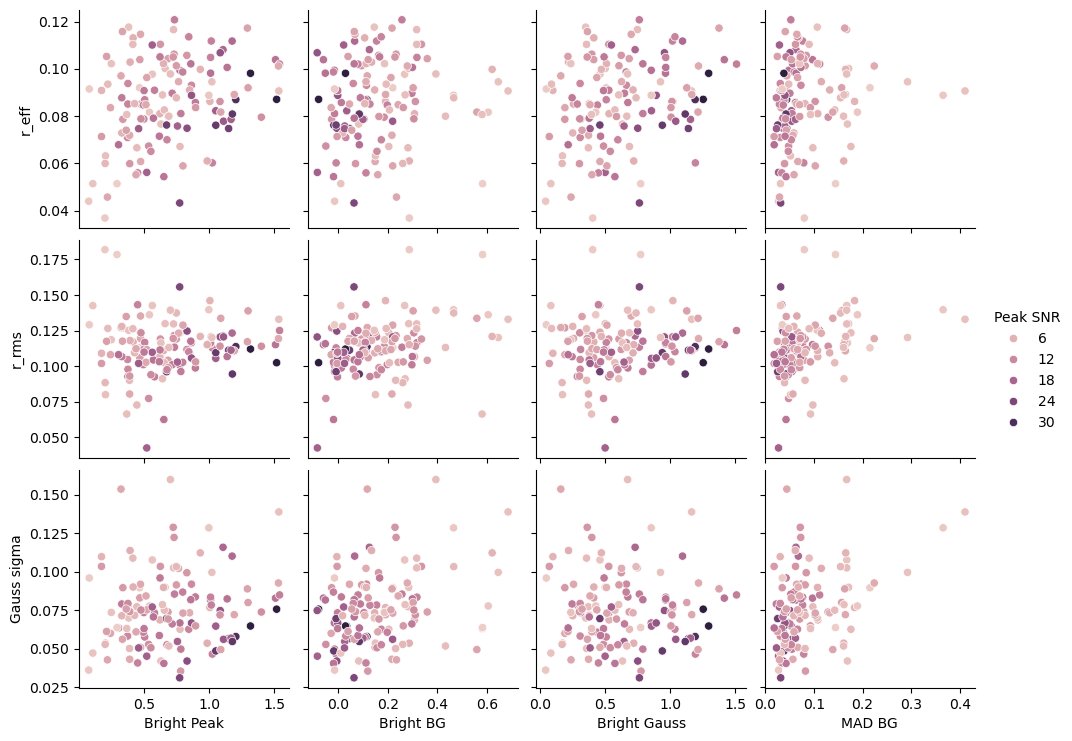

In [398]:
sns.pairplot(peakdfs["AA"], x_vars=bcols, y_vars=rcols, hue="Peak SNR")

In [399]:
peakdfs["DD"][rcols + bcols].corr()

r_eff     r_rms  Gauss sigma  Bright Peak  Bright BG  \
r_eff         1.000000  0.024393     0.384387     0.012974  -0.040370   
r_rms         0.024393  1.000000     0.272708    -0.062198   0.314126   
Gauss sigma   0.384387  0.272708     1.000000    -0.126873   0.217355   
Bright Peak   0.012974 -0.062198    -0.126873     1.000000  -0.173989   
Bright BG    -0.040370  0.314126     0.217355    -0.173989   1.000000   
Bright Gauss  0.058137  0.081648     0.053733     0.055963  -0.020331   
MAD BG        0.042771  0.152838     0.347171     0.463334   0.051170   

              Bright Gauss    MAD BG  
r_eff             0.058137  0.042771  
r_rms             0.081648  0.152838  
Gauss sigma       0.053733  0.347171  
Bright Peak       0.055963  0.463334  
Bright BG        -0.020331  0.051170  
Bright Gauss      1.000000  0.056936  
MAD BG            0.056936  1.000000

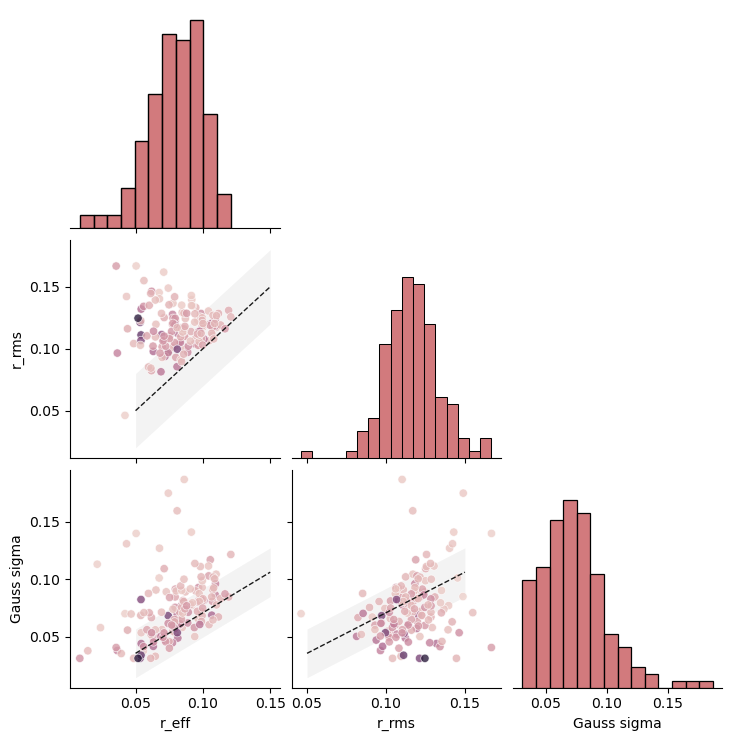

In [490]:
rpairplot("DD", [0.05, 0.15])

All these show a wide dispersion in r_rms when r_eff is small. Why is this?

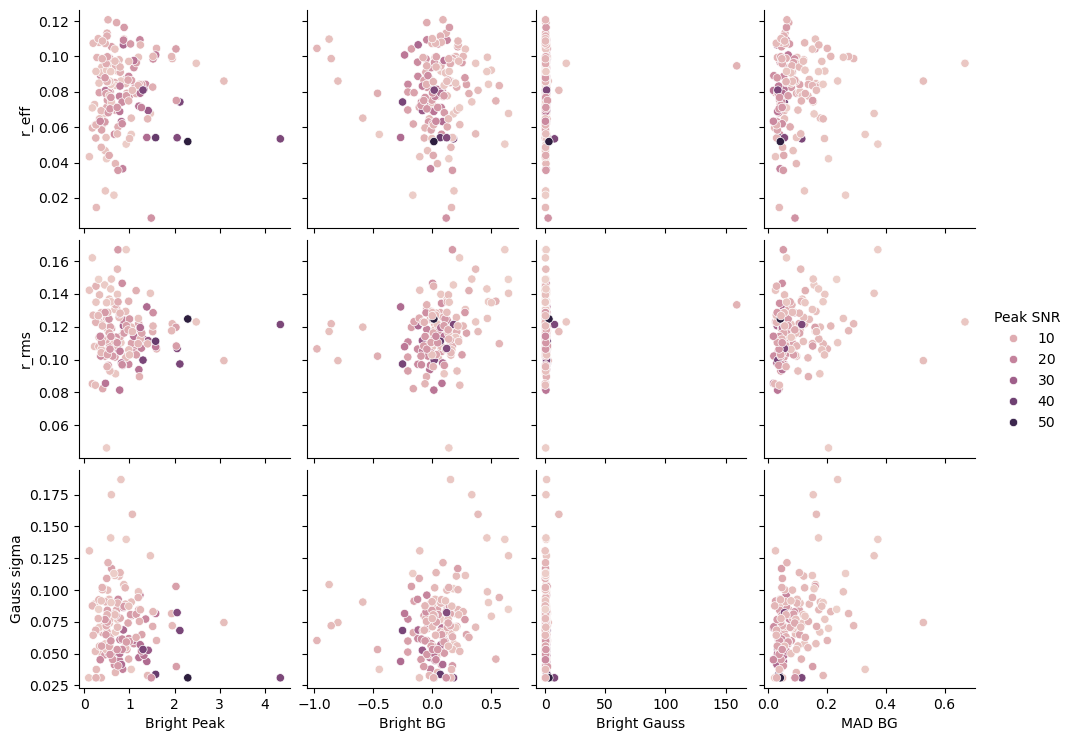

In [401]:
sns.pairplot(peakdfs["DD"], x_vars=bcols, y_vars=rcols, hue="Peak SNR")

### Correlations in r_eff between the combos

In [402]:
def cross_corr(combo1, combo2, cols=rcols + bcols):
    return peakdfs[combo1][cols].corrwith(peakdfs[combo2][cols], axis=0)

In [403]:
cross_corr("H", "E")

r_eff           0.559315
r_rms           0.282478
Gauss sigma     0.590341
Bright Peak     0.832230
Bright BG       0.915642
Bright Gauss    0.787268
MAD BG          0.736441
dtype: float64

In [404]:
cross_corr("E", "D")

r_eff           0.177937
r_rms          -0.092221
Gauss sigma     0.125010
Bright Peak     0.688125
Bright BG       0.674003
Bright Gauss    0.626050
MAD BG          0.425583
dtype: float64

Not much correlation between ionized and neutral

Better to make a new dataframe with all the r_eff columns

In [405]:
rdf = pd.DataFrame(
    {combo: peakdfs[combo]["r_eff"].values for combo in peakdfs},
    index=peakdfs["E"].index,
)

In [406]:
rdf.describe()

AA          DD           D           E           H
count  128.000000  155.000000  151.000000  143.000000  160.000000
mean     0.086094    0.079721    0.123104    0.120092    0.135546
std      0.018123    0.021306    0.021201    0.028477    0.021335
min      0.036828    0.008589    0.042087    0.008357    0.056848
25%      0.075567    0.067975    0.113479    0.104172    0.120880
50%      0.086960    0.080985    0.124326    0.122561    0.140086
75%      0.100286    0.096401    0.135925    0.139678    0.151421
max      0.120789    0.120751    0.170080    0.174826    0.185845

In [407]:
rdf.corr()

AA        DD         D         E         H
AA  1.000000  0.724942  0.374835  0.256612  0.299608
DD  0.724942  1.000000  0.214358  0.308768  0.223208
D   0.374835  0.214358  1.000000  0.177937  0.209801
E   0.256612  0.308768  0.177937  1.000000  0.559315
H   0.299608  0.223208  0.209801  0.559315  1.000000

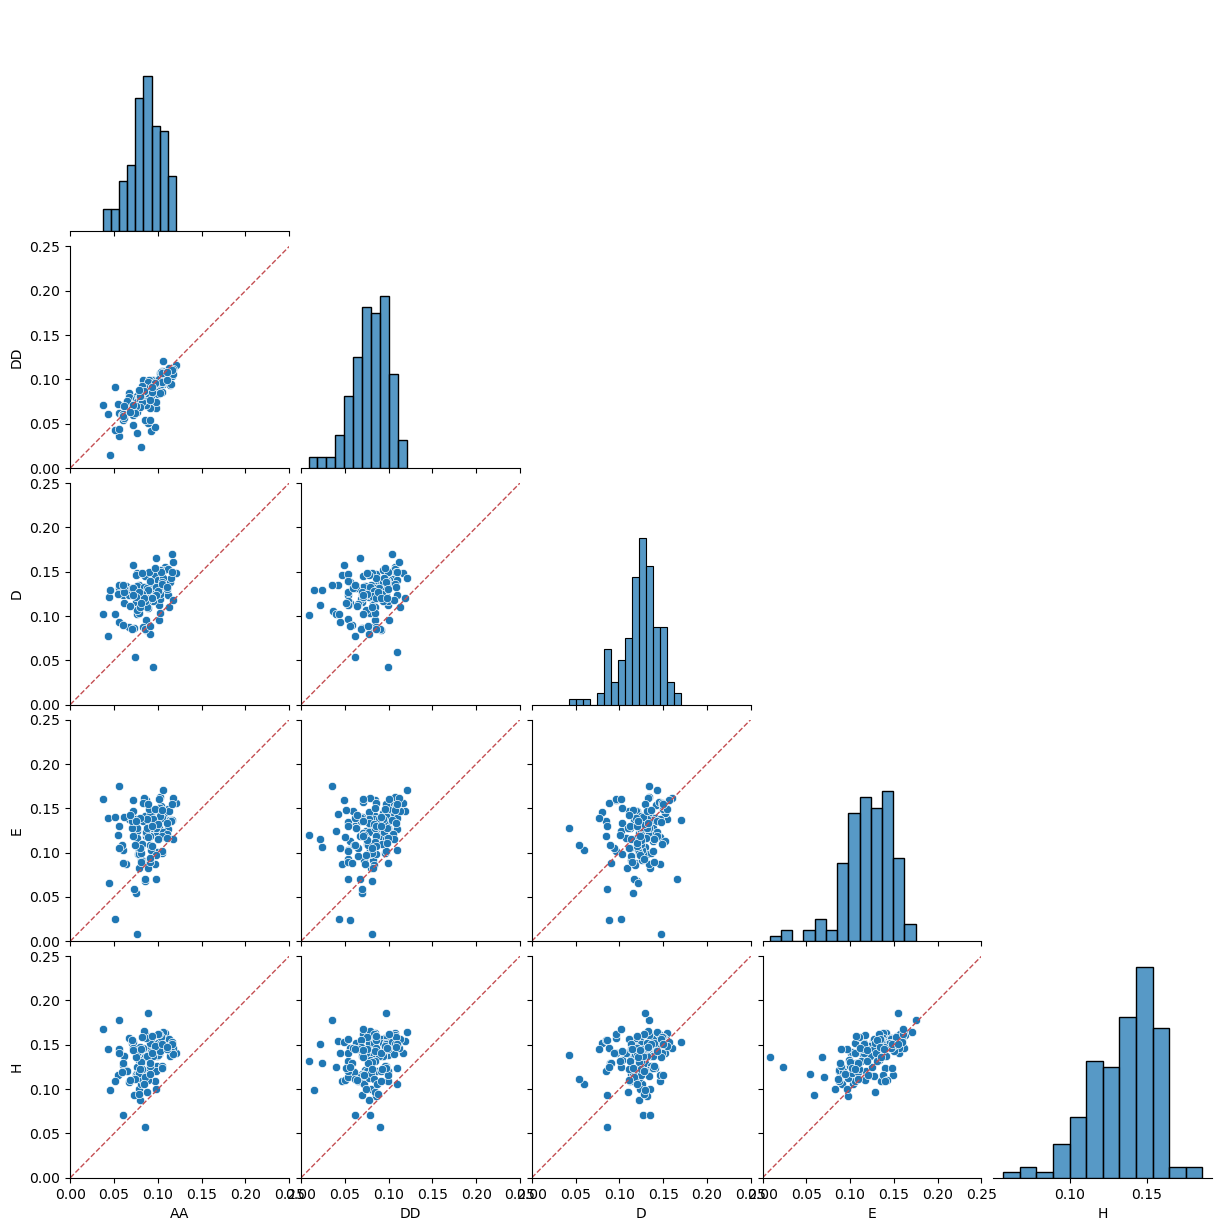

In [408]:
g = sns.pairplot(rdf, corner=True)
vmin, vmax = 0, 0.25
for idx in zip(*np.tril_indices_from(g.axes, -1)):
    g.axes[idx].plot([vmin, vmax], [vmin, vmax], "--", color="r", lw=1)
    g.axes[idx].set(xlim=[vmin, vmax], ylim=[vmin, vmax])


So the best correlations are E-H and AA-DD, as expected. They all show some degree of correlation, generally r > 0.3, except for D, which is uncorrelated with anything. 

### Correlations in r_rms between the combos

Just for completeness, we will also do r_rms. 

In [409]:
rrdf = pd.DataFrame(
    {combo: peakdfs[combo]["r_rms"].values for combo in peakdfs},
    index=peakdfs["E"].index,
)

In [410]:
rrdf.describe()

AA          DD           D           E           H
count  127.000000  148.000000  154.000000  148.000000  161.000000
mean     0.113474    0.116496    0.155391    0.148148    0.143193
std      0.018922    0.017232    0.016736    0.029144    0.017104
min      0.042619    0.046203    0.118454    0.061617    0.076845
25%      0.103076    0.106280    0.143470    0.133576    0.135425
50%      0.113110    0.116117    0.153761    0.147277    0.144858
75%      0.123192    0.125635    0.165630    0.157228    0.151563
max      0.181761    0.166820    0.220151    0.256166    0.200971

In [411]:
rrdf.corr()

AA        DD         D         E         H
AA  1.000000  0.655430  0.172417  0.107469  0.147557
DD  0.655430  1.000000  0.162624  0.095052  0.155275
D   0.172417  0.162624  1.000000 -0.092221  0.107692
E   0.107469  0.095052 -0.092221  1.000000  0.282478
H   0.147557  0.155275  0.107692  0.282478  1.000000

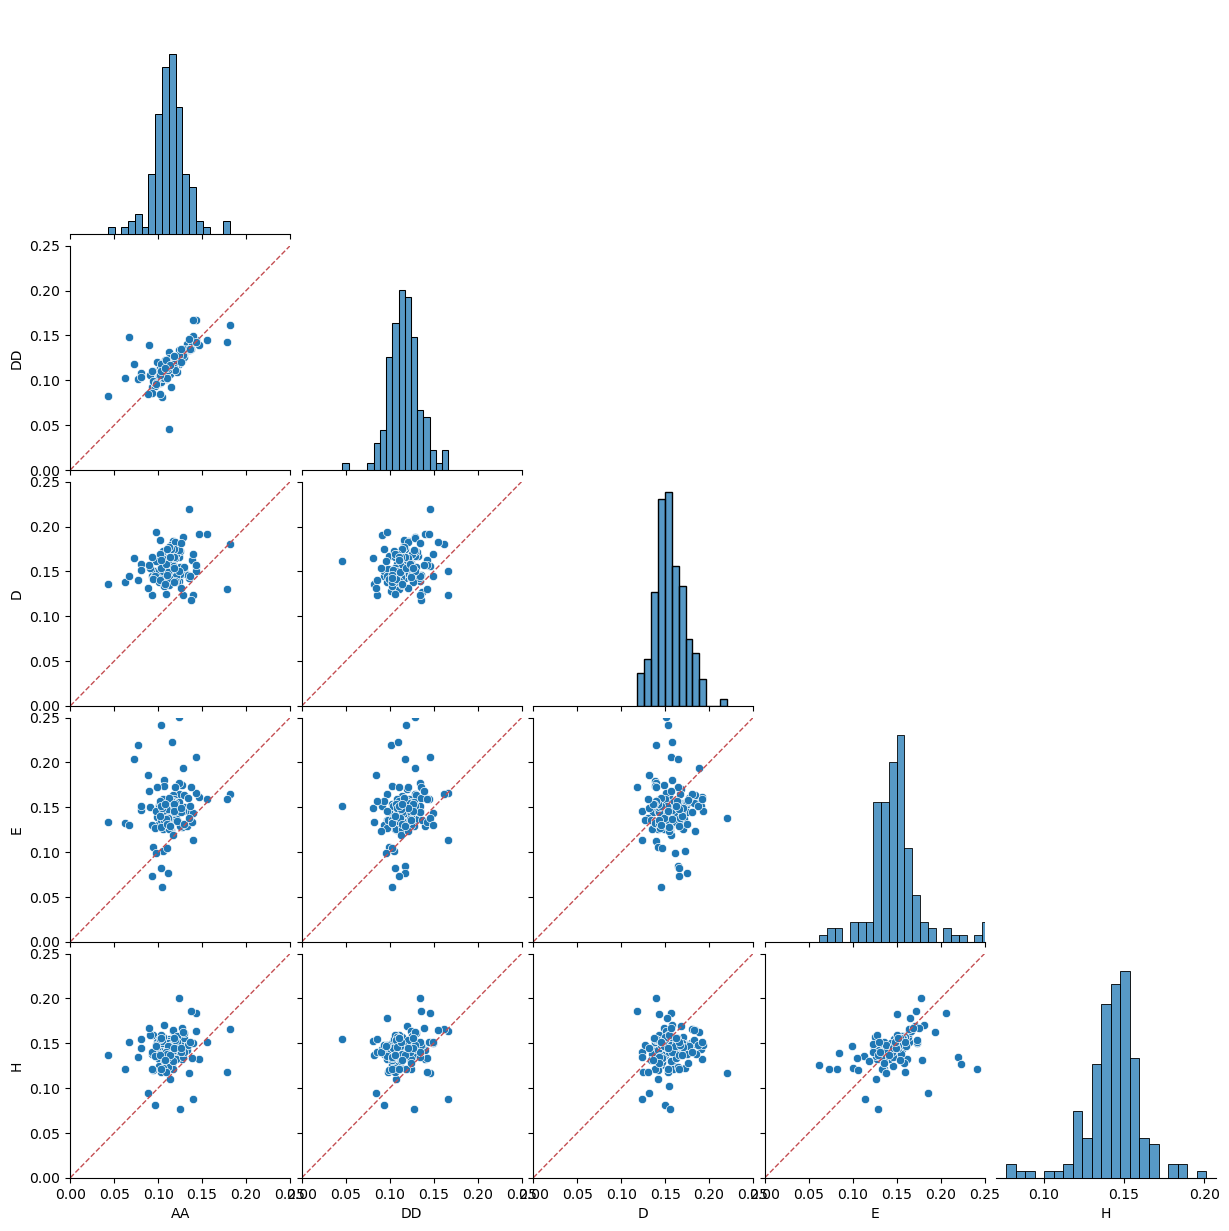

In [412]:
g = sns.pairplot(rrdf, corner=True)
vmin, vmax = 0, 0.25
for idx in zip(*np.tril_indices_from(g.axes, -1)):
    g.axes[idx].plot([vmin, vmax], [vmin, vmax], "--", color="r", lw=1)
    g.axes[idx].set(xlim=[vmin, vmax], ylim=[vmin, vmax])

This is not so dissimilar, except thar r_rms does not have the tail towards low values that r_eff does. 

The AA-DD correlation is even better than with r_eff, although the E-H correlation is a bit weaker. Again, D has low correlation with everything

In [468]:
grdf = pd.DataFrame(
    {combo: peakdfs[combo]["Gauss sigma"].values for combo in peakdfs},
    index=peakdfs["E"].index,
)

In [469]:
grdf.describe()

AA          DD           D           E           H
count  127.000000  152.000000  155.000000  154.000000  165.000000
mean     0.075050    0.073601    0.109051    0.121335    0.121711
std      0.023785    0.027144    0.019688    0.034876    0.027978
min      0.031000    0.031000    0.064853    0.031000    0.031000
25%      0.057673    0.055349    0.096373    0.099746    0.103782
50%      0.073346    0.070966    0.105765    0.115653    0.117178
75%      0.087748    0.087191    0.116574    0.140426    0.134857
max      0.159792    0.186848    0.186424    0.225506    0.227197

In [470]:
grdf.corr()

AA        DD         D         E         H
AA  1.000000  0.651378  0.270559  0.221265  0.240823
DD  0.651378  1.000000  0.252884  0.200313  0.198968
D   0.270559  0.252884  1.000000  0.125010  0.165282
E   0.221265  0.200313  0.125010  1.000000  0.590341
H   0.240823  0.198968  0.165282  0.590341  1.000000

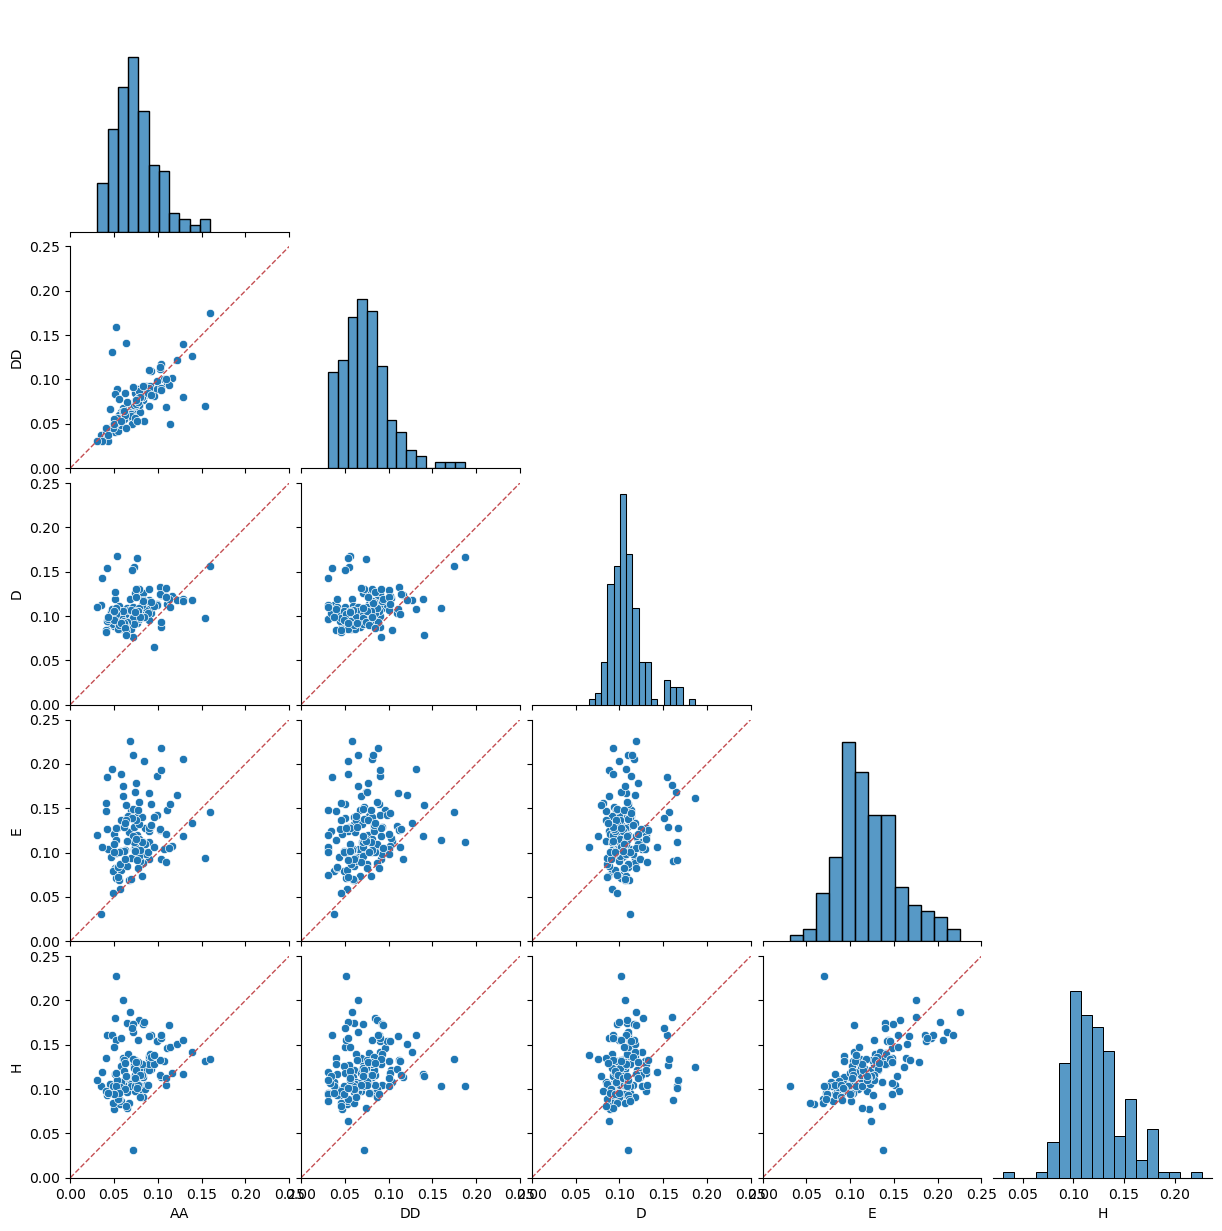

In [471]:
g = sns.pairplot(grdf, corner=True)
vmin, vmax = 0, 0.25
for idx in zip(*np.tril_indices_from(g.axes, -1)):
    g.axes[idx].plot([vmin, vmax], [vmin, vmax], "--", color="r", lw=1)
    g.axes[idx].set(xlim=[vmin, vmax], ylim=[vmin, vmax])

## Combine r_eff with dr

In [413]:
drcols = [_ for _ in dr_table.colnames if _.startswith("dR")]
drdf = dr_table.to_pandas().set_index("label")[drcols]

In [414]:
drdf.describe()

dR(AA-D)    dR(DD-D)    dR(EE-D)
count  168.000000  168.000000  168.000000
mean     0.085560    0.073168    0.080267
std      0.074087    0.098691    0.094062
min     -0.160717   -0.479362   -0.249390
25%      0.046616    0.044192    0.034202
50%      0.080540    0.072164    0.082803
75%      0.127263    0.115126    0.126160
max      0.410410    0.373487    0.375196

In [415]:
clip_dataframe(drdf, drcols, sig=3)
drdf.describe()

dR(AA-D)    dR(DD-D)    dR(EE-D)
count  162.000000  161.000000  162.000000
mean     0.087633    0.077015    0.080613
std      0.059648    0.071400    0.079269
min     -0.059916   -0.113824   -0.146760
25%      0.047867    0.045436    0.037083
50%      0.080819    0.072670    0.082803
75%      0.125772    0.107909    0.122553
max      0.257887    0.261382    0.309835

### Correlations between r_eff and dr

In [416]:
df = rdf.join(drdf)

In [417]:
df.corr()

AA        DD         D         E         H  dR(AA-D)  \
AA        1.000000  0.724942  0.374835  0.256612  0.299608  0.122356   
DD        0.724942  1.000000  0.214358  0.308768  0.223208  0.095707   
D         0.374835  0.214358  1.000000  0.177937  0.209801 -0.042390   
E         0.256612  0.308768  0.177937  1.000000  0.559315  0.088540   
H         0.299608  0.223208  0.209801  0.559315  1.000000  0.139319   
dR(AA-D)  0.122356  0.095707 -0.042390  0.088540  0.139319  1.000000   
dR(DD-D)  0.098011  0.014489  0.105012  0.095667  0.051530  0.605597   
dR(EE-D)  0.113272  0.039941  0.083094  0.045909  0.069851  0.426066   

          dR(DD-D)  dR(EE-D)  
AA        0.098011  0.113272  
DD        0.014489  0.039941  
D         0.105012  0.083094  
E         0.095667  0.045909  
H         0.051530  0.069851  
dR(AA-D)  0.605597  0.426066  
dR(DD-D)  1.000000  0.391448  
dR(EE-D)  0.391448  1.000000

Uh, oh. Those correlations do not look great

In [418]:
combos = list(peakdfs.keys())

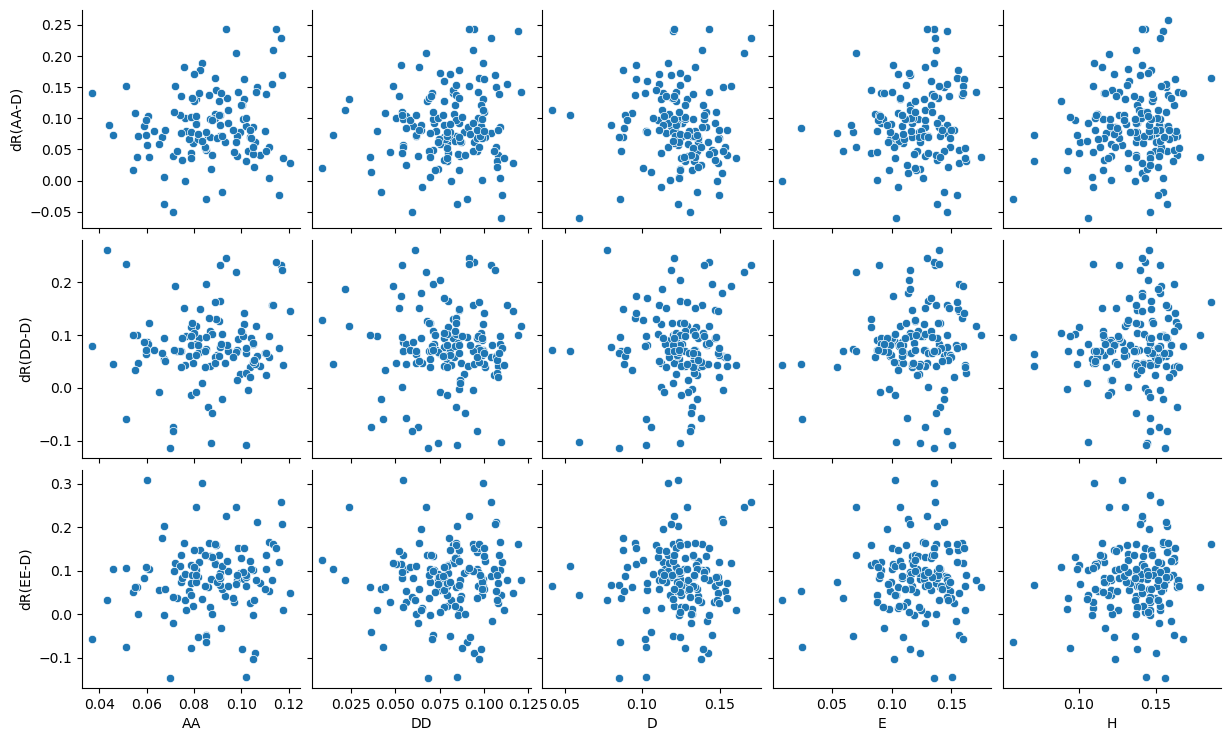

In [419]:
g = sns.pairplot(df, x_vars=combos, y_vars=drcols)

In [420]:
ddf = rrdf.join(drdf)

In [421]:
ddf.corr()

AA        DD         D         E         H  dR(AA-D)  \
AA        1.000000  0.655430  0.172417  0.107469  0.147557  0.152216   
DD        0.655430  1.000000  0.162624  0.095052  0.155275  0.188931   
D         0.172417  0.162624  1.000000 -0.092221  0.107692  0.230457   
E         0.107469  0.095052 -0.092221  1.000000  0.282478 -0.149378   
H         0.147557  0.155275  0.107692  0.282478  1.000000  0.066206   
dR(AA-D)  0.152216  0.188931  0.230457 -0.149378  0.066206  1.000000   
dR(DD-D)  0.251183  0.219521  0.098064  0.026698  0.009134  0.605597   
dR(EE-D) -0.036949  0.136487  0.112583 -0.161837 -0.052897  0.426066   

          dR(DD-D)  dR(EE-D)  
AA        0.251183 -0.036949  
DD        0.219521  0.136487  
D         0.098064  0.112583  
E         0.026698 -0.161837  
H         0.009134 -0.052897  
dR(AA-D)  0.605597  0.426066  
dR(DD-D)  1.000000  0.391448  
dR(EE-D)  0.391448  1.000000

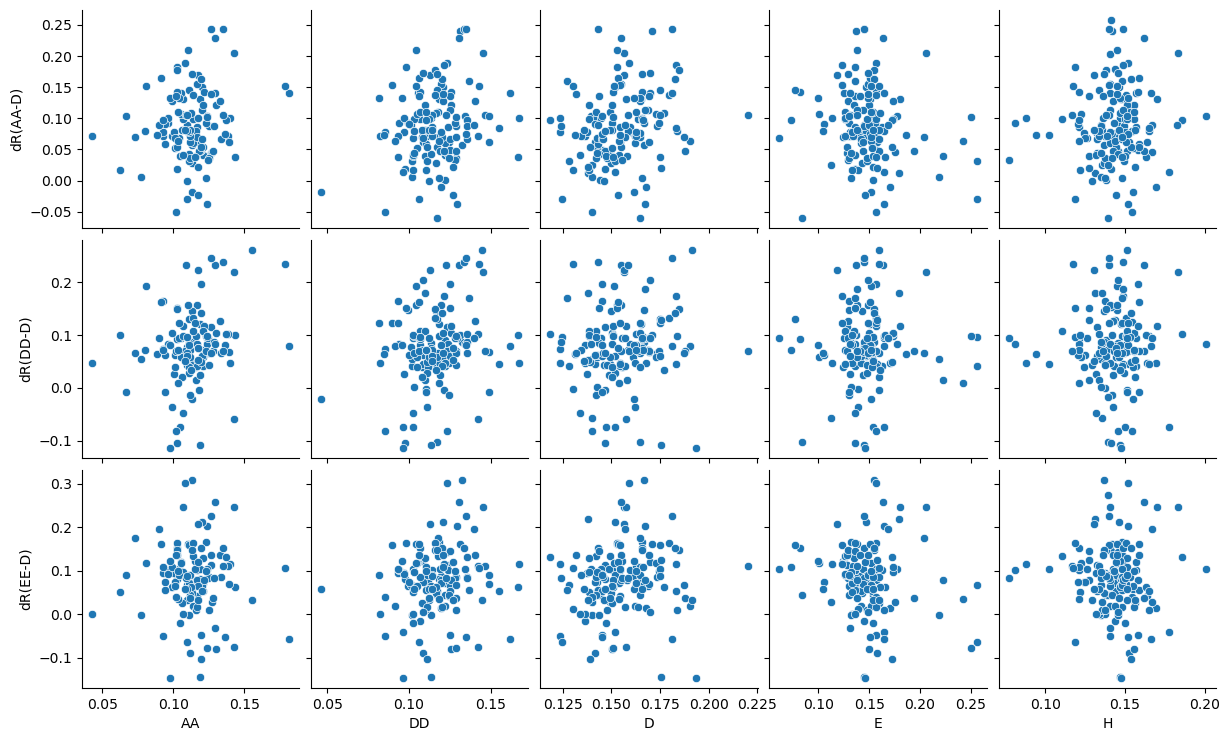

In [422]:
g = sns.pairplot(ddf, x_vars=combos, y_vars=drcols)

Unfortunately, there are no strong correlations here at all

## A new way of doing dR

We can just find the scalar separation between the peaks. 

In [458]:
def sep_arcsec(combo1, combo2, coord_name="Peak Center"):
    return ptables[combo1][coord_name].separation(ptables[combo2][coord_name]).arcsec

Package these up in a new dataframe, sepdf

In [424]:
pairs = [["AA", "D"], ["DD", "D"], ["E", "D"]]
paircols = [f"{pair[0]}-{pair[1]}" for pair in pairs]
sepdf = pd.DataFrame(
    {col:  sep_arcsec(*pair) for col, pair in zip(paircols, pairs)},
    index=peakdfs["E"].index,
)
sepdf.describe()

AA-D        DD-D         E-D
count  168.000000  168.000000  168.000000
mean     0.127293    0.129755    0.154405
std      0.071265    0.080141    0.101043
min      0.000342    0.016899    0.000000
25%      0.070571    0.069161    0.069771
50%      0.099877    0.101912    0.127438
75%      0.166015    0.160180    0.219535
max      0.373465    0.420932    0.416413

And repeat for the Gaussians

In [460]:
gsepdf = pd.DataFrame(
    {col:  sep_arcsec(*pair, coord_name="Gauss Center") for col, pair in zip(paircols, pairs)},
    index=peakdfs["E"].index,
)
gsepdf.describe()

AA-D        DD-D         E-D
count  168.000000  168.000000  168.000000
mean     0.137138    0.150410    0.181904
std      0.109773    0.164802    0.156070
min      0.015170    0.005725    0.008846
25%      0.076826    0.071864    0.080964
50%      0.106709    0.100398    0.135829
75%      0.149879    0.159625    0.241323
max      0.617039    1.441726    1.253831

In [461]:
sepdf.corrwith(gsepdf)

AA-D    0.599071
DD-D    0.558499
E-D     0.537686
dtype: float64

### Correlations within these new separations

In [425]:
sepdf.corr()

AA-D      DD-D       E-D
AA-D  1.000000  0.690507  0.204264
DD-D  0.690507  1.000000  0.350090
E-D   0.204264  0.350090  1.000000

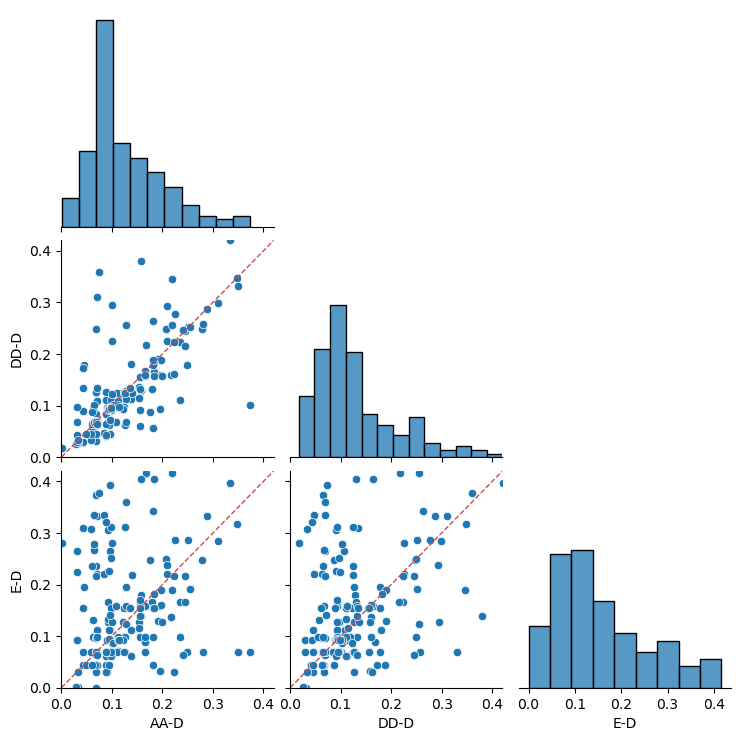

In [463]:
g = sns.pairplot(sepdf, corner=True)
vmin, vmax = 0, 0.42
for idx in zip(*np.tril_indices_from(g.axes, -1)):
    g.axes[idx].plot([vmin, vmax], [vmin, vmax], "--", color="r", lw=1)
    g.axes[idx].set(xlim=[vmin, vmax], ylim=[vmin, vmax])

They all show some corrrelation. DD-D versus AA-D is the tightest. Even the worst case of E-D versus AA-D looks like it is a reasonable correlation plus a bunch of outliers.

~Also note the discretization in the values, which is due to using pixel centers.~ Not aanymore since I swirched to subpixel center.

In [462]:
gsepdf.corr()

AA-D      DD-D       E-D
AA-D  1.000000  0.761827  0.197129
DD-D  0.761827  1.000000  0.141278
E-D   0.197129  0.141278  1.000000

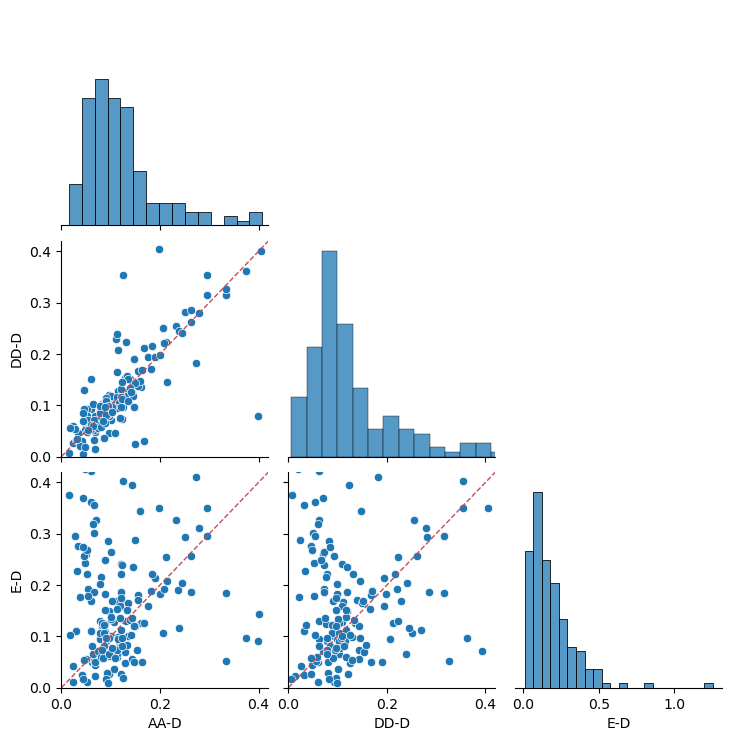

In [464]:
g = sns.pairplot(gsepdf, corner=True)
vmin, vmax = 0, 0.42
for idx in zip(*np.tril_indices_from(g.axes, -1)):
    g.axes[idx].plot([vmin, vmax], [vmin, vmax], "--", color="r", lw=1)
    g.axes[idx].set(xlim=[vmin, vmax], ylim=[vmin, vmax])

The gaussian version shows tighter correlation of AA-D with DD-D, but worso on the others

### Per-combo r_eff values versus new separations

In [427]:
df2 = rdf.join(sepdf)

In [428]:
df2.corr()

AA        DD         D         E         H      AA-D      DD-D  \
AA    1.000000  0.724942  0.374835  0.256612  0.299608 -0.003550  0.037461   
DD    0.724942  1.000000  0.214358  0.308768  0.223208 -0.052726  0.051014   
D     0.374835  0.214358  1.000000  0.177937  0.209801 -0.161528 -0.095735   
E     0.256612  0.308768  0.177937  1.000000  0.559315  0.028851 -0.013549   
H     0.299608  0.223208  0.209801  0.559315  1.000000  0.132676  0.136831   
AA-D -0.003550 -0.052726 -0.161528  0.028851  0.132676  1.000000  0.690507   
DD-D  0.037461  0.051014 -0.095735 -0.013549  0.136831  0.690507  1.000000   
E-D  -0.048094 -0.061752  0.081093 -0.018736 -0.098865  0.204264  0.350090   

           E-D  
AA   -0.048094  
DD   -0.061752  
D     0.081093  
E    -0.018736  
H    -0.098865  
AA-D  0.204264  
DD-D  0.350090  
E-D   1.000000

Not good - nearly all negative

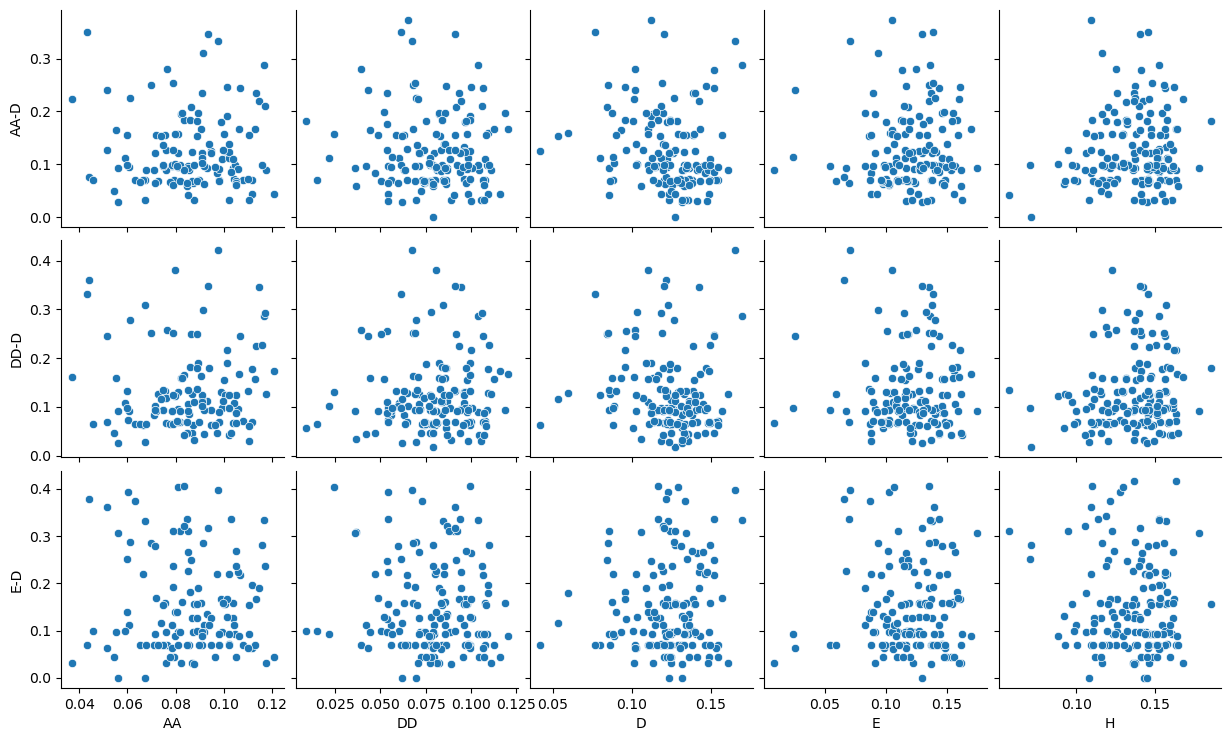

In [429]:
g = sns.pairplot(df2, x_vars=combos, y_vars=paircols)

### Per-combo r_rms values versus new separations

In [430]:
ddf2 = rrdf.join(sepdf)

In [465]:
ddf2.corr()

AA        DD         D         E         H      AA-D      DD-D  \
AA    1.000000  0.655430  0.172417  0.107469  0.147557  0.305612  0.331940   
DD    0.655430  1.000000  0.162624  0.095052  0.155275  0.139903  0.221654   
D     0.172417  0.162624  1.000000 -0.092221  0.107692  0.432202  0.287725   
E     0.107469  0.095052 -0.092221  1.000000  0.282478 -0.063572 -0.078366   
H     0.147557  0.155275  0.107692  0.282478  1.000000  0.123334  0.137423   
AA-D  0.305612  0.139903  0.432202 -0.063572  0.123334  1.000000  0.690507   
DD-D  0.331940  0.221654  0.287725 -0.078366  0.137423  0.690507  1.000000   
E-D   0.119272  0.086380 -0.062136  0.280841  0.206944  0.204264  0.350090   

           E-D  
AA    0.119272  
DD    0.086380  
D    -0.062136  
E     0.280841  
H     0.206944  
AA-D  0.204264  
DD-D  0.350090  
E-D   1.000000

At least some of these are positive, but none are strong. 

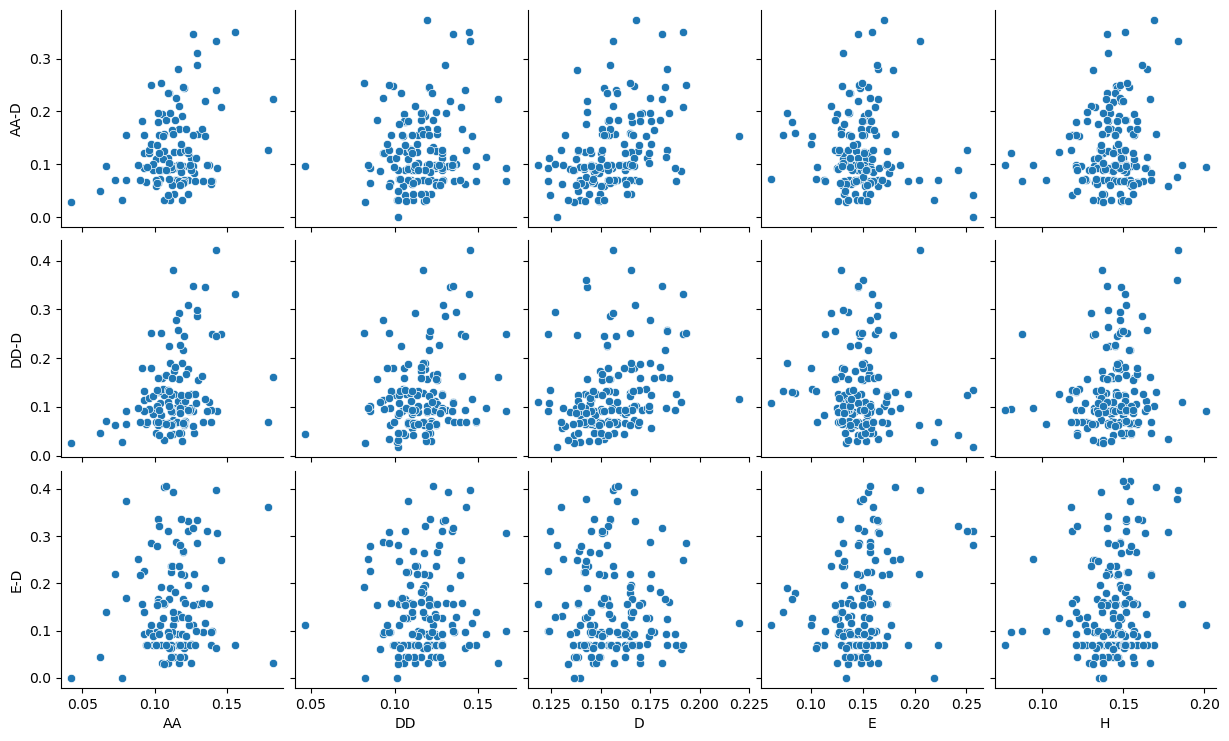

In [432]:
g = sns.pairplot(ddf2, x_vars=combos, y_vars=paircols)

Note that we would not necessarily expect for there to be a perfect relation between the dR offsets and the sizes, since it would depend a bit on the inclination angle. The model predictions are a bit complex, but if the knot is well resolved then the displacement should be higher as a fraction of the knot size when the inclination angle is low (close to the plane of sky)

In case we ever want to extract the separations from the labels without bothering to load a different file, then this is one way to do it:

In [433]:
R_knots = 0.1 * drdf.index.str.slice(start=-3).values.astype(int)
R_knots

array([16.3, 15.3, 16.4, 10.1, 17.8, 18.5,  3.8,  5.4,  3.3, 14.7, 13.8,
       12.6, 13.9,  8.3, 11.1,  7.7, 16.8, 10.7, 11. ,  4.9, 12.6, 13.9,
       12. ,  4.4, 13.4, 10.8, 14.7,  3.2, 14.8, 17.2, 18.3,  3.5, 14.5,
       15.9, 16.6, 21.9, 21.2, 21.9, 18.3, 11.7, 22.6, 11.2, 26.8, 13.8,
       20.2, 27.4, 25.9, 27.3, 30.8, 12.1, 13.7, 15.8, 18.7, 19.7, 21.5,
       12.3, 20.4, 15.3, 25.6, 26.1,  9.3, 10.2, 15.1, 14.5, 11.6, 14.9,
       32.9, 33.6, 33.1, 35.1, 17.1, 27.5, 33.7, 12.2, 13.1, 25.7, 11.3,
       17.4, 13.3, 16.2,  7.5, 22.2, 23.2,  8.5, 13. , 17.4, 18.9, 11.9,
        7.1, 22.5, 11.4, 17.6, 29.3,  6.6, 10.5, 20.4, 27.4, 14.6, 11.2,
       17.8, 18.5,  6.8, 20.6, 10.2, 11. , 20. , 19.1, 22.5, 23.4, 11.9,
       21.5, 18. , 20. , 10.2, 17.8, 12.2, 14.1, 18.1, 19.8, 21.5, 19.7,
        9.2, 23.5, 18.9, 24.9, 28.4, 26.6, 20.5, 28.6, 11. , 23.4, 21.7,
       23.4, 26.9, 28.7, 27.5, 24.9, 25.2, 26.7,  6.8,  9.8,  6.4, 18.9,
       22. , 22.4, 23.7, 19.8, 10.4,  3. ,  7.7,  9

### Intercomparison of the two offset methods

In [434]:
df3 = drdf.join(sepdf)

In [435]:
df3.corr()

dR(AA-D)  dR(DD-D)  dR(EE-D)      AA-D      DD-D       E-D
dR(AA-D)  1.000000  0.605597  0.426066  0.546649  0.497178  0.150599
dR(DD-D)  0.605597  1.000000  0.391448  0.427187  0.482154  0.139358
dR(EE-D)  0.426066  0.391448  1.000000  0.273003  0.328060  0.290062
AA-D      0.546649  0.427187  0.273003  1.000000  0.690507  0.204264
DD-D      0.497178  0.482154  0.328060  0.690507  1.000000  0.350090
E-D       0.150599  0.139358  0.290062  0.204264  0.350090  1.000000

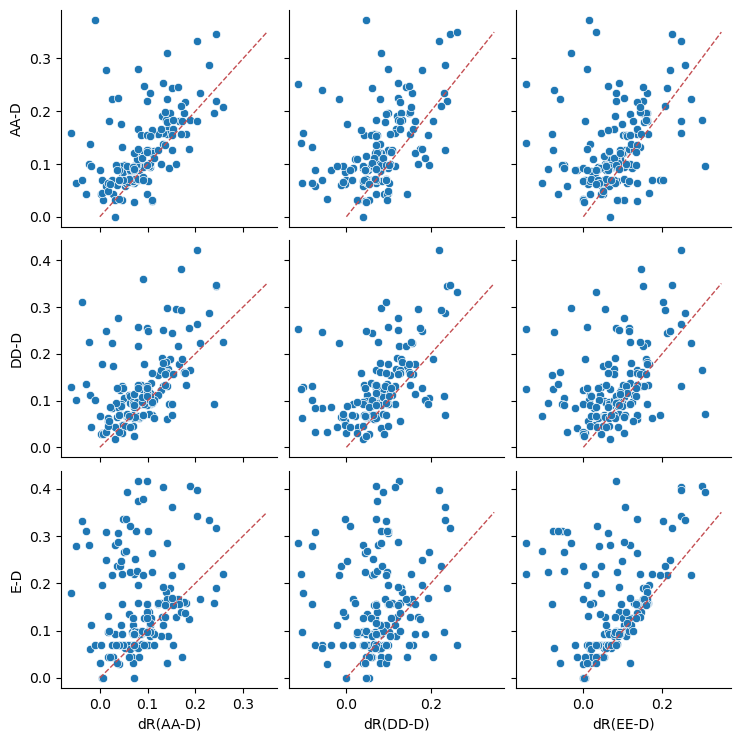

In [436]:
g = sns.pairplot(df3, x_vars=drcols, y_vars=paircols)
vmin, vmax = 0.0, 0.35
for ax in g.axes.flat:
    ax.plot([vmin, vmax], [vmin, vmax], "--", color="r", lw=1)

What to concentrate on is the leading diagonal of subplots, which compares two different measures of the displacement between the same pair of combo images. 

This seems to offer a way to get a quality filter on the displacements. The x axis is the displacement between the flux barycenters along a radius from the star, while the y axis is the scalar separation (irrespective of direction) between the peak intensity pixels.

So any shift between peak and barycenter or any non-radial component to the displacement will produce deviation from the red line. In the latter case, the points will only move up.

For completeness, repeat for offsets between gaussian centers

In [476]:
gdf3 = drdf.join(gsepdf)

In [477]:
gdf3.corr()

dR(AA-D)  dR(DD-D)  dR(EE-D)      AA-D      DD-D       E-D
dR(AA-D)  1.000000  0.605597  0.426066  0.222664  0.257037 -0.063612
dR(DD-D)  0.605597  1.000000  0.391448  0.268945  0.214293 -0.010769
dR(EE-D)  0.426066  0.391448  1.000000  0.167963  0.237078  0.120517
AA-D      0.222664  0.268945  0.167963  1.000000  0.761827  0.197129
DD-D      0.257037  0.214293  0.237078  0.761827  1.000000  0.141278
E-D      -0.063612 -0.010769  0.120517  0.197129  0.141278  1.000000

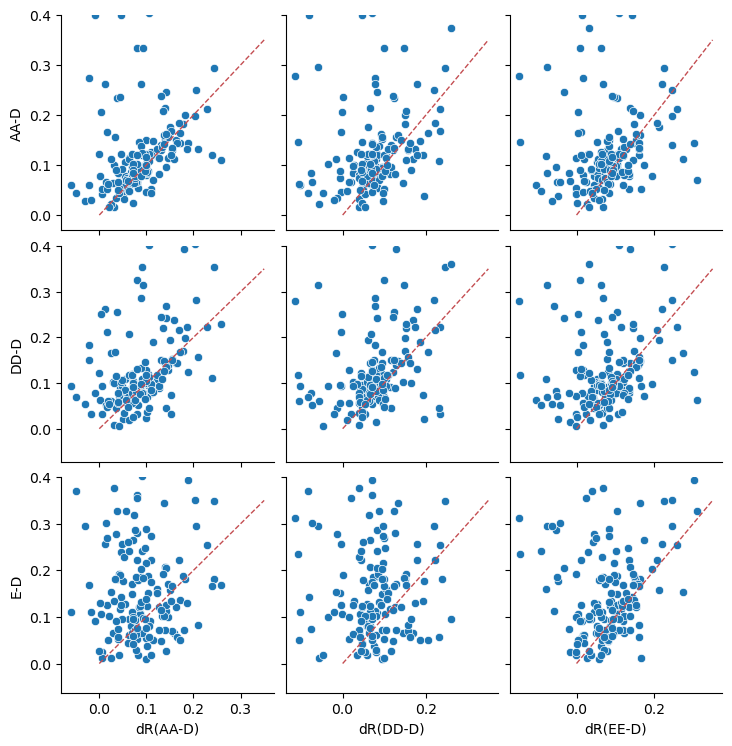

In [479]:
g = sns.pairplot(gdf3, x_vars=drcols, y_vars=paircols)
vmin, vmax = 0.0, 0.35
for ax in g.axes.flat:
    ax.plot([vmin, vmax], [vmin, vmax], "--", color="r", lw=1)
    ax.set(ylim=[None, 0.4]) # trim outliers

## Combining the two dr methods

So we can take all knots were the x-y discrepancy is less than a certain amount, say 0.05

In [437]:
def best_dr(pair, max_diff=0.05):
    """Return average of two dr estimates, but only if they more or less agree"""
    dr1 = df3[pair]
    dr2 = df3[f"dR({pair.replace('E', 'EE')})"]    
    mean_ = (dr1 + dr2) / 2
    diff_ = np.abs(dr1 - dr2)
    return np.where(diff_ <= max_diff, mean_, np.nan)

In [438]:
bsepdf = sepdf.copy()

In [439]:
for col in bsepdf.columns.values:
    bsepdf[col] = best_dr(col, 0.08)

In [440]:
bsepdf.corr()

AA-D      DD-D       E-D
AA-D  1.000000  0.767055  0.675962
DD-D  0.767055  1.000000  0.559933
E-D   0.675962  0.559933  1.000000

In [441]:
bsepdf.describe()

AA-D        DD-D         E-D
count  136.000000  122.000000  116.000000
mean     0.100339    0.093660    0.100194
std      0.050201    0.051264    0.054569
min      0.006434   -0.007291   -0.000750
25%      0.066554    0.062781    0.066470
50%      0.087552    0.084070    0.091485
75%      0.129792    0.111517    0.136475
max      0.258743    0.296289    0.295563

[(0.0, 0.29), (0.0, 0.29)]

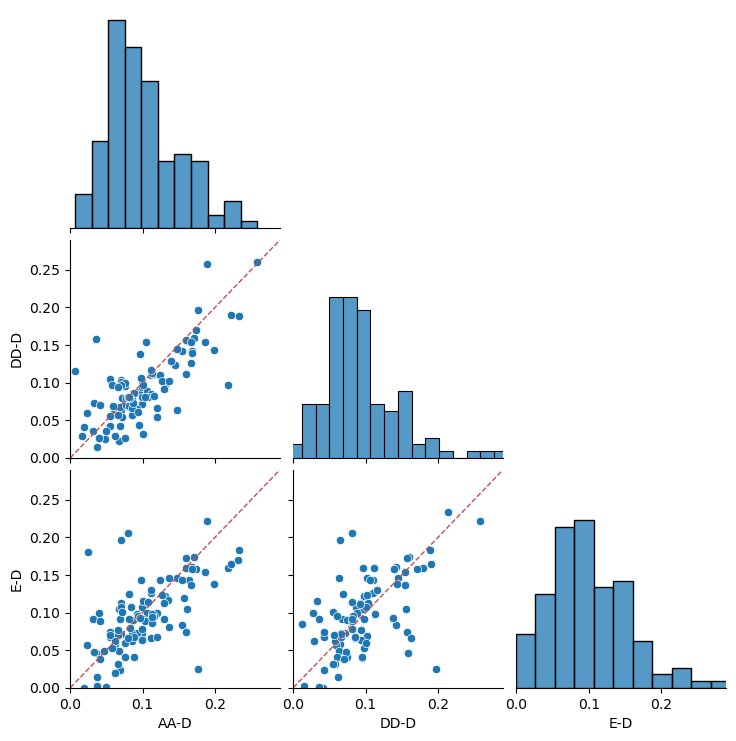

In [442]:
g = sns.pairplot(bsepdf, corner=True)
vmin, vmax = 0, 0.29
for idx in zip(*np.tril_indices_from(g.axes, -1)):
    g.axes[idx].plot([vmin, vmax], [vmin, vmax], "--", color="r", lw=1)
    g.axes[idx].set(xlim=[vmin, vmax], ylim=[vmin, vmax])
g.axes[-1, -1].set(xlim=[vmin, vmax], ylim=[vmin, vmax])

This is much better.

In [472]:
df4 = rdf.join(bsepdf)
ddf4 = rrdf.join(bsepdf)
gdf4 = grdf.join(bsepdf)

In [444]:
df4.corr()

AA        DD         D         E         H      AA-D      DD-D  \
AA    1.000000  0.724942  0.374835  0.256612  0.299608 -0.117789  0.018289   
DD    0.724942  1.000000  0.214358  0.308768  0.223208 -0.087259  0.004597   
D     0.374835  0.214358  1.000000  0.177937  0.209801 -0.025649  0.020852   
E     0.256612  0.308768  0.177937  1.000000  0.559315 -0.040741  0.056345   
H     0.299608  0.223208  0.209801  0.559315  1.000000 -0.119221 -0.034140   
AA-D -0.117789 -0.087259 -0.025649 -0.040741 -0.119221  1.000000  0.767055   
DD-D  0.018289  0.004597  0.020852  0.056345 -0.034140  0.767055  1.000000   
E-D   0.007483  0.070311 -0.015136  0.112815 -0.076990  0.675962  0.559933   

           E-D  
AA    0.007483  
DD    0.070311  
D    -0.015136  
E     0.112815  
H    -0.076990  
AA-D  0.675962  
DD-D  0.559933  
E-D   1.000000

In [445]:
ddf4.corr()

AA        DD         D         E         H      AA-D      DD-D  \
AA    1.000000  0.655430  0.172417  0.107469  0.147557 -0.043404 -0.024752   
DD    0.655430  1.000000  0.162624  0.095052  0.155275  0.045762  0.051638   
D     0.172417  0.162624  1.000000 -0.092221  0.107692 -0.000773 -0.036779   
E     0.107469  0.095052 -0.092221  1.000000  0.282478 -0.029120  0.011325   
H     0.147557  0.155275  0.107692  0.282478  1.000000 -0.082182 -0.037805   
AA-D -0.043404  0.045762 -0.000773 -0.029120 -0.082182  1.000000  0.767055   
DD-D -0.024752  0.051638 -0.036779  0.011325 -0.037805  0.767055  1.000000   
E-D   0.004153  0.023577 -0.139160  0.056686  0.005936  0.675962  0.559933   

           E-D  
AA    0.004153  
DD    0.023577  
D    -0.139160  
E     0.056686  
H     0.005936  
AA-D  0.675962  
DD-D  0.559933  
E-D   1.000000

In [473]:
gdf4.corr()

AA        DD         D         E         H      AA-D      DD-D  \
AA    1.000000  0.651378  0.270559  0.221265  0.240823 -0.205483 -0.171380   
DD    0.651378  1.000000  0.252884  0.200313  0.198968 -0.108604 -0.088113   
D     0.270559  0.252884  1.000000  0.125010  0.165282 -0.123660 -0.142647   
E     0.221265  0.200313  0.125010  1.000000  0.590341 -0.114518 -0.018019   
H     0.240823  0.198968  0.165282  0.590341  1.000000 -0.261888 -0.224787   
AA-D -0.205483 -0.108604 -0.123660 -0.114518 -0.261888  1.000000  0.767055   
DD-D -0.171380 -0.088113 -0.142647 -0.018019 -0.224787  0.767055  1.000000   
E-D  -0.087107 -0.032293 -0.158292 -0.066099 -0.182798  0.675962  0.559933   

           E-D  
AA   -0.087107  
DD   -0.032293  
D    -0.158292  
E    -0.066099  
H    -0.182798  
AA-D  0.675962  
DD-D  0.559933  
E-D   1.000000

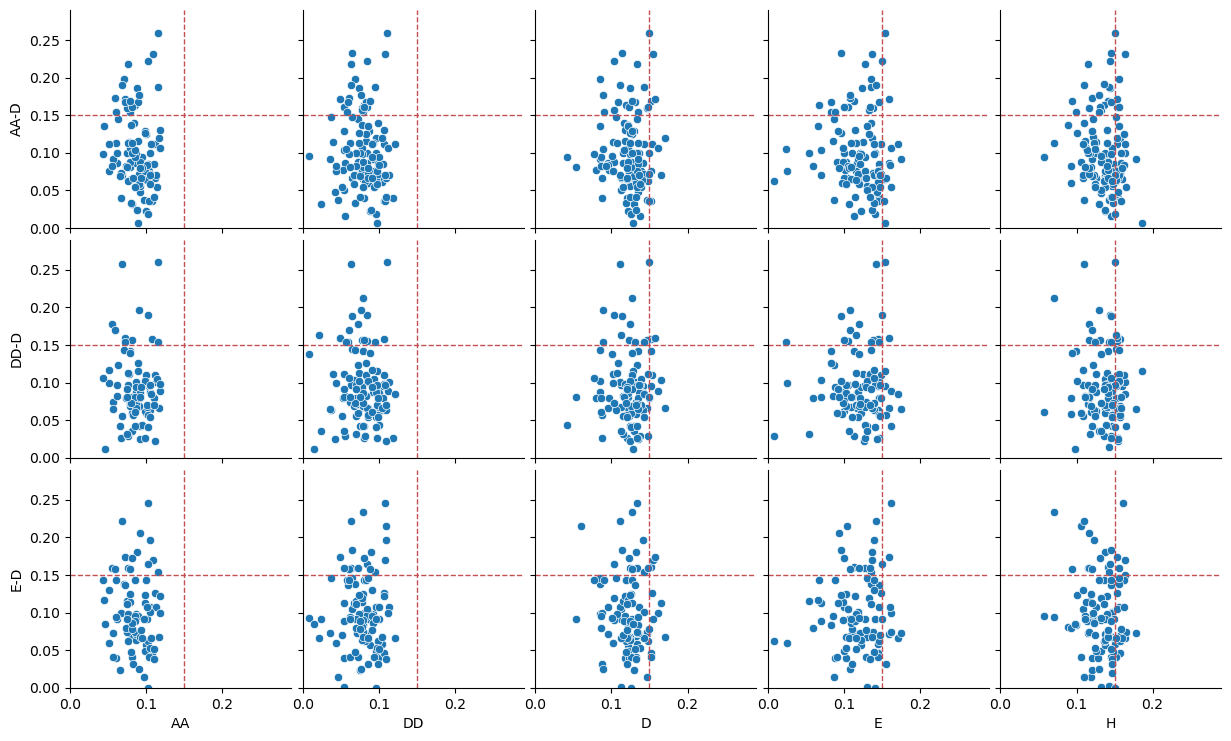

In [446]:
g = sns.pairplot(df4, x_vars=combos, y_vars=paircols)
vmin, vmax = 0.0, 0.29
for ax in g.axes.flat:
    ax.set(xlim=[vmin, vmax], ylim=[vmin, vmax])
    ax.axvline(0.15, ls="--", color="r", lw=1)
    ax.axhline(0.15, ls="--", color="r", lw=1)

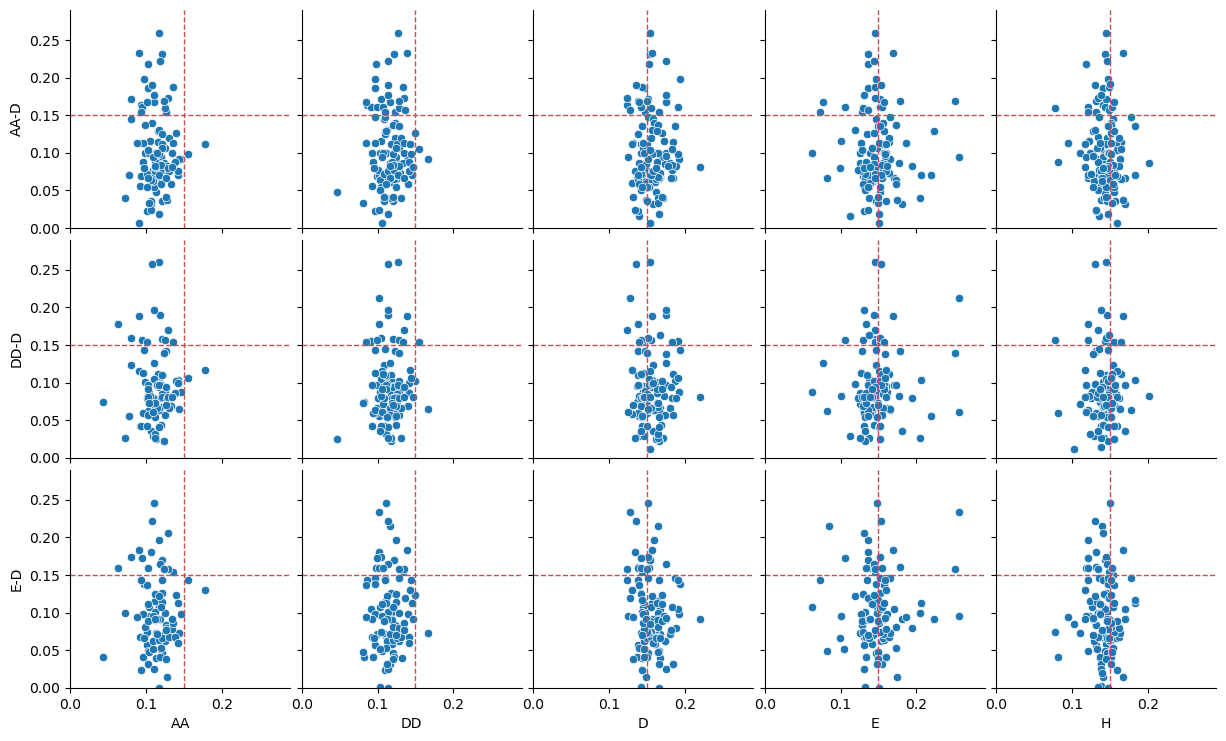

In [447]:
g = sns.pairplot(ddf4, x_vars=combos, y_vars=paircols)
vmin, vmax = 0.0, 0.29
for ax in g.axes.flat:
    ax.set(xlim=[vmin, vmax], ylim=[vmin, vmax])
    ax.axvline(0.15, ls="--", color="r", lw=1)
    ax.axhline(0.15, ls="--", color="r", lw=1)

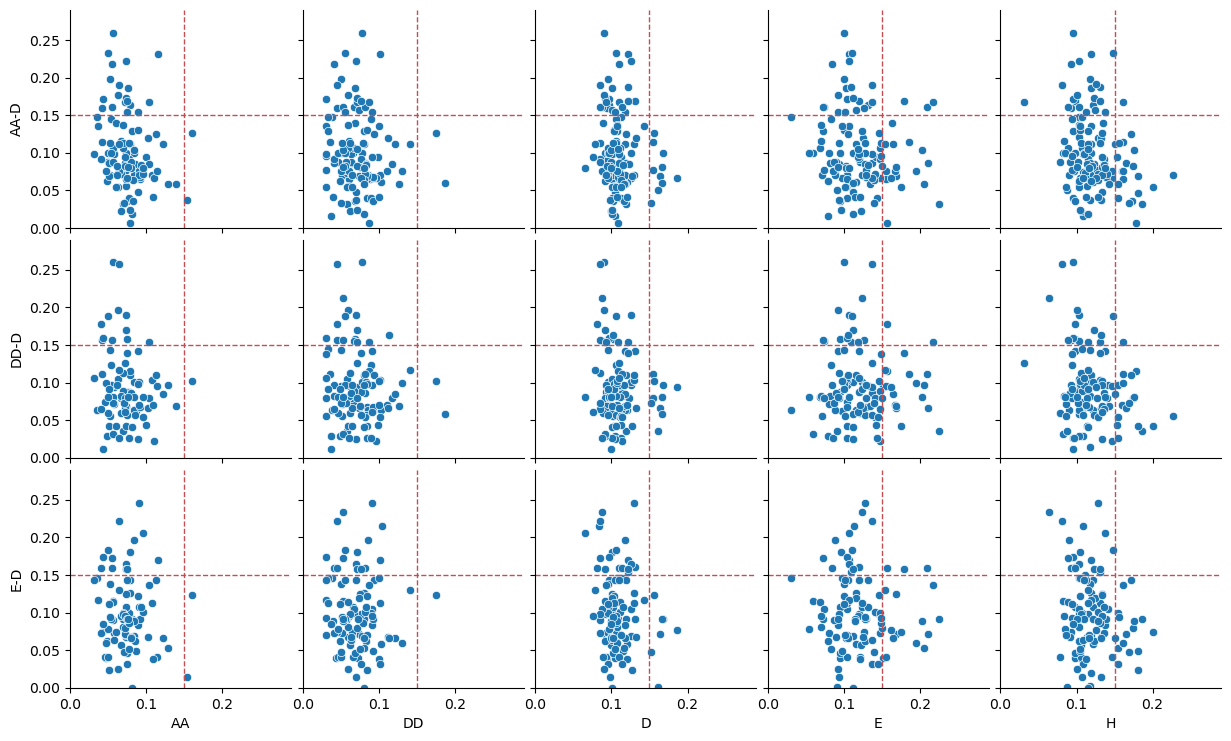

In [475]:
g = sns.pairplot(gdf4, x_vars=combos, y_vars=paircols)
vmin, vmax = 0.0, 0.29
for ax in g.axes.flat:
    ax.set(xlim=[vmin, vmax], ylim=[vmin, vmax])
    ax.axvline(0.15, ls="--", color="r", lw=1)
    ax.axhline(0.15, ls="--", color="r", lw=1)

So the rms radii look more convincing for most pairs

## Theoretical relation between the different widths

We can investigate this empirically

In [448]:
from astropy.convolution import Gaussian2DKernel, convolve

Start with pure gaussian profile 

In [532]:
def gaussian_radii(sigma, aperture_radius=0.25, pixel_scale=0.033):
    """Find the 2d RMS radius and effective radius of gaussian in aperture"""
    # Enough pixels to span the radius from the center
    nr = 1 + int(aperture_radius / pixel_scale)
    # Size of array to fully enclose the aperture, such that [nr, nr] is center
    n = 2 * nr + 1
    # Construct cartesian pixel coordinates wrt center 
    x, y = np.indices((n, n))
    x -= nr
    y -= nr
    # Radius from center of each pixel
    r = np.hypot(x, y)
    # Image is delta function in central pixel
    im = np.zeros((n, n))
    im[nr, nr] = 1.0
    # Convolve with gaussian of rms width sigma
    kernel = Gaussian2DKernel(x_stddev=sigma / pixel_scale)
    im = convolve(im, kernel, boundary="extend")
    # Crop at edge of aperture
    im[r > aperture_radius / pixel_scale] = 0.0
    
    # Calculate RMS weighted radius
    r_rms = np.sqrt(np.average(r ** 2, weights=im)) * pixel_scale
    # Cqlculate effective area in pixels
    A_eff = np.sum(im) / np.max(im)
    # And effective radius
    r_eff = np.sqrt(A_eff / np.pi) * pixel_scale
    return f"{r_eff=} {r_rms=}"

Parameters for explaining D results (aperture of 0.25)

In [533]:
gaussian_radii(0.095, aperture_radius=0.25)

'r_eff=0.13211255929489082 r_rms=0.1262571382049827'

AA, DD used smaller aperture ...

In [534]:
gaussian_radii(0.095, aperture_radius=0.2)

'r_eff=0.12641675667761784 r_rms=0.11400227549332417'

So we see that the reduction in rms radius is about 10%

In [535]:
gaussian_radii(0.095, aperture_radius=0.15)

'r_eff=0.11526178810307354 r_rms=0.09686530221056917'

Now try a homogeneous sphere

In [541]:
def sphere_radii(rsphere, sigma=0.0, aperture_radius=0.25, pixel_scale=0.033):
    """Find the 2d RMS radius and effective radius of a filled sphere source in aperture"""
    # Enough pixels to span the radius from the center
    nr = 1 + int(aperture_radius / pixel_scale)
    # Size of array to fully enclose the aperture, such that [nr, nr] is center
    n = 2 * nr + 1
    # Construct cartesian pixel coordinates wrt center 
    x, y = np.indices((n, n))
    x -= nr
    y -= nr
    # Radius from center of each pixel
    r = np.hypot(x, y)
    # Image is filled homogeneous emission sphere
    im = np.where(
        r <= (rsphere / pixel_scale),
        np.sqrt((rsphere / pixel_scale) ** 2 - r ** 2),
        0.0,
    )
    if sigma > 0.0:
        # Convolve with gaussian of rms width sigma
        kernel = Gaussian2DKernel(x_stddev=sigma / pixel_scale)
        im = convolve(im, kernel, boundary="extend")
    # Crop at edge of aperture
    im[r > aperture_radius / pixel_scale] = 0.0
        
    # Calculate RMS weighted radius
    r_rms = np.sqrt(np.average(r ** 2, weights=im)) * pixel_scale
    print(np.pi * (aperture_radius / pixel_scale)**2)
    # Calculate effective area in pixels
    A_eff = np.sum(im) / np.max(im)
    npix = np.sum(im > 0)
    # And effective radius
    r_eff = np.sqrt(A_eff / np.pi) * pixel_scale
    return f"{A_eff=} {r_eff=} {r_rms=}  {npix=}"

First we try a very large sphere in a unit radius aperture

In [542]:
sphere_radii(1e10, aperture_radius=1.0)

2884.841738833602


'A_eff=2885.000000000001 r_eff=1.0000274294069227 r_rms=0.707124468193682  npix=2885'

This gives r_eff = 1 as expected, and it seems that r_rms is sqrt(2)/2

Now try a smaller sphere

In [550]:
sphere_radii(1, sigma=0.0, aperture_radius=2) 

11539.366955334408


/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_29556/3545103463.py:16: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((rsphere / pixel_scale) ** 2 - r ** 2),


'A_eff=1923.4638276003952 r_eff=0.8165466760534079 r_rms=0.6325151065634957  npix=2885'

## Summary

- The 2d rms radius works best for most combos. After filtering out some outliers this gives
  - D: 0.16 +/- 0.02
  - E: 0.15 +/- 0.03
  - H: 0.14 +/- 0.02
  - AA: 0.11 +/- 0.02
  - DD: 0.12 +/- 0.02
- The relation between 2d rms radius and sigma is r_rms = sqrt(2) sigma
- These need to corrected for the psf broadening, which is characterised by fwhm
  - D, E: 0.146 -> 0.09 (2d rms)
  - AA, DD: 0.07 -> 0.04 (2d rms)
  - H is compicated: 0.07 but then undersampled in pixels of 0.10 => 0.12 -> 0.07
  - But we need to conform the rms widths to fwhm: larger by 2 sqrt(ln(2)) = 1.67
- Resultant psf-subtracted 2D RMS widths
  - D: 0.13
  - E: 0.12
  - H: 0.12
  - AA: 0.10
  - DD: 0.11
- These are all remarkably similar, so we could use an average of 0.12 on the 2D rms scale
- It remains to be seen how this relates to the radius r0 of the ionization front
  - [ ] We can do models for this. The easiest would be for a filled homogeneous emission sphere, but we could also do the photoevaporation models. And take into acount the psf broadening
  - Looks like we get r_rms = 0.63 r0 for the filled sphere case so r0 = 1.6 r_rms
  - So, approximately we have r0 = FWHM, so it would be better to put all widths on the fwhm scale from the start.
  - **So we find r0 = 0.22 +/- 0.03**
- Then the offsets are found to have a much broader distribution
  - dr = 0.10 +/- 0.05
  - dr/r0 ranges roughly between 0 and 1, just as we would expect
  - Hopefully it can be used as a diagnostic of the inclination




In [494]:
ddf4[combos].describe()

AA          DD           D           E           H
count  127.000000  148.000000  154.000000  148.000000  161.000000
mean     0.113474    0.116496    0.155391    0.148148    0.143193
std      0.018922    0.017232    0.016736    0.029144    0.017104
min      0.042619    0.046203    0.118454    0.061617    0.076845
25%      0.103076    0.106280    0.143470    0.133576    0.135425
50%      0.113110    0.116117    0.153761    0.147277    0.144858
75%      0.123192    0.125635    0.165630    0.157228    0.151563
max      0.181761    0.166820    0.220151    0.256166    0.200971

In [551]:
ddf4[paircols].describe()

AA-D        DD-D         E-D
count  136.000000  122.000000  116.000000
mean     0.100339    0.093660    0.100194
std      0.050201    0.051264    0.054569
min      0.006434   -0.007291   -0.000750
25%      0.066554    0.062781    0.066470
50%      0.087552    0.084070    0.091485
75%      0.129792    0.111517    0.136475
max      0.258743    0.296289    0.295563

Conversion from 2D RMS to 1D FWHM

In [553]:
fac = 2*np.sqrt(np.log(2))
fac

1.6651092223153954

Create a final dataframe with median of FWHM psf-coreected widths and the median offsets

In [575]:
r0_label = "knot radius, $r_0$, arcsec"
dr_label = "ionized–neutral offset, $dr$, arcsec"
fpdf = pd.DataFrame(
    {
        r0_label: np.nanmean(
            np.stack(
                [
                    np.sqrt((fac * ddf4["AA"]) ** 2 - 0.073**2),
                    np.sqrt((fac * ddf4["DD"]) ** 2 - 0.073**2),
                    np.sqrt((fac * ddf4["D"]) ** 2 - 0.146**2),
                    np.sqrt((fac * ddf4["E"]) ** 2 - 0.146**2),
                    np.sqrt((fac * ddf4["H"]) ** 2 - 0.068**2 - 0.1**2),
                ], axis=0,
            ), axis=0,
        ),
        dr_label: np.nanmean(
            np.stack(
                [ddf4["AA-D"], ddf4["DD-D"], ddf4["E-D"]], axis=0,
            ), axis=0,
        ),
    },
    index=peakdfs["E"].index,
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_29556/1769676409.py:5: RuntimeWarning: Mean of empty slice
  r0_label: np.nanmean(
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_29556/1769676409.py:16: RuntimeWarning: Mean of empty slice
  dr_label: np.nanmean(


In [576]:
fpdf.describe()

knot radius, $r_0$, arcsec  ionized–neutral offset, $dr$, arcsec
count                  167.000000                            151.000000
mean                     0.196024                              0.098756
std                      0.021720                              0.047869
min                      0.135887                              0.014831
25%                      0.183316                              0.066128
50%                      0.196101                              0.086547
75%                      0.207513                              0.126045
max                      0.259519                              0.271414

In [577]:
sns.set_context("talk")

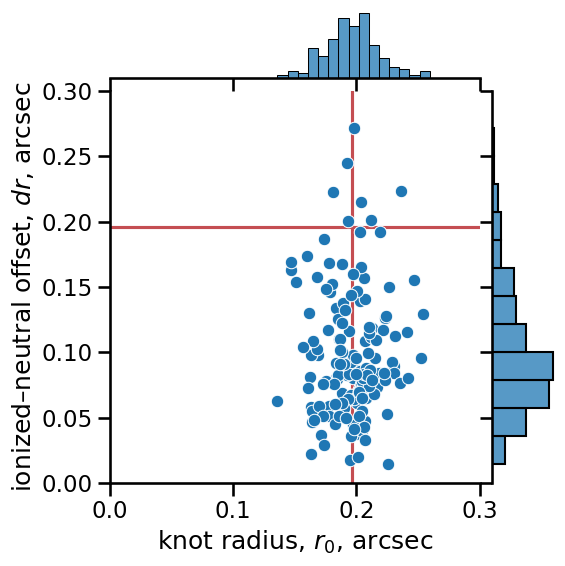

In [578]:
g = sns.jointplot(fpdf, x=r0_label, y=dr_label, xlim=[0, 0.3], ylim=[0, 0.3])
g.ax_joint.axvline(fpdf[r0_label].mean(), color="r", zorder=-1)
g.ax_joint.axhline(fpdf[r0_label].mean(), color="r", zorder=-1)
...;

In [579]:
g.savefig("mean-r0-dr-distribution.pdf")